# Analysis of Experiment P3128

## Outline

1.  [Loading data](#Loading).  See the P1902 Preprocessing notebook, for the preparation of this data. 

2.  [Protein and mRNA distributions](#Protein) within and between clones for markers where we have information about both.

3. [Gene expressions as a signature of clonality](#Signature)  A machine learning approach to studying whether gene expression can predict clonotype.

4. [Differential gene expression](#DGE), including within and across traditional EFF/MEM categories.

<a id='Loading'></a>
# 1.  Loading and munging data

We begin by importing various packages and functions.  This notebook requires Python 3.5 or later, together with numpy, pandas, matplotlib, seaborn, statsmodels, scipy, scikit-learn (sklearn), bisect, and itertools.

In [1]:
#Import packages.  Put plots "inline" in the notebook.  

import numpy as np  # For numerical computations.
import pandas as pd  # Pandas for data analysis.
import matplotlib.pyplot as plt  # For basic plotting.
import seaborn as sns # For pretty visualization in Seaborn.  See https://seaborn.pydata.org/
import statsmodels.api as sm

from IPython.display import display # Pretty display of data frames.

# Import various functions for stats.
from scipy.stats import f_oneway, binom, binom_test, kruskal, norm # For p-values, kruskal-wallis, Gaussian
from scipy.stats import kurtosis, skew, zscore # For detecting bimodality
import scipy.cluster.hierarchy as sch # For hierarchical clustering.

from statsmodels.formula.api import ols

from bisect import bisect # See bisect.bisect.
from itertools import compress # Nice way to apply masks to lists, etc.

# Import from scikit, for machine learning.
# from sklearn import mixture  # Import Gaussian mixture

from sklearn.preprocessing import Binarizer, MinMaxScaler
from sklearn.model_selection import ShuffleSplit, train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import BernoulliNB, GaussianNB # Naive Bayes Classifiers.
from sklearn.ensemble import VotingClassifier # Voting classifier.
from sklearn.svm import LinearSVC, NuSVC, SVC # Support Vector Machine 
from sklearn.pipeline import make_pipeline, Pipeline 
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics.pairwise import pairwise_distances_argmin
from sklearn.manifold import TSNE

# Put plots inline rather than in a pop-up.
%matplotlib inline

All data should be available from three pickles, produced by the Preprocessing notebook.

In [2]:
EM = pd.read_pickle('P3128_EM.pkl') # Load normalized expression matrix from a pickle.
protein_df = pd.read_pickle('P3128_protein.pkl') # Load proteins from a pickle.
meta_df = pd.read_pickle('P3128_meta.pkl') # Load metadata from a pickle.

We retrieve lists of genes, cells, and proteins from the loaded data.

In [3]:
genes = list(EM.columns)  # The names of the genes. 
cells = list(EM.index) # The names of the cells.

proteins = list(protein_df.columns) # The names of the proteins
paired_proteins = [p for p in proteins if p in genes] # Proteins with paired genes.

clones = sorted(meta_df['Clone_ID'].unique() )

`meta_df` is the dataframe holding the "metadata" of each cell (not the gene/protein expressions).  Let's just look at the first five cells, to see what the metadata looks like.

In [4]:
meta_df[:5]

,Project_ID,Donor,Number_Of_Cells,Clone_ID,In_Vivo_Clone_ID
Sample_ID,,,,,
P3128_1193,P3128,YFV2001,1,D2,3.0
P3128_1194,P3128,YFV2001,1,D2,3.0
P3128_1195,P3128,YFV2001,1,D2,3.0
P3128_1196,P3128,YFV2001,1,D2,3.0
P3128_1197,P3128,YFV2001,1,D2,3.0


We combine the (in vitro) clone id and the in vivo clone id, into one new column for later convenience.

In [6]:
meta_df = meta_df.fillna(0)
meta_df['iv'] = meta_df.Clone_ID + '_' + meta_df.In_Vivo_Clone_ID.astype(int).astype(str)
print(sorted(meta_df['iv'].unique()))

['A2_7', 'A7_32', 'A8_1', 'B10_54', 'B12_13', 'B4_54', 'B6_8', 'C2_18', 'C6_9', 'D10_47', 'D1_48', 'D2_3', 'D6_55', 'E2_1', 'E7_13', 'E8_6', 'F11_14', 'F4_12', 'F6_27', 'F7_41', 'G3_29', 'H3_11', 'H4_0', 'H4_11', 'H4_54', 'H6_44']


In [7]:
innate_df = pd.read_csv('InnateDB_genes.csv')
extragenes = pd.read_csv('marty-extra_genes.csv')
genes_innate = set(innate_df.name.unique()).union(set(extragenes.name.unique()))
genes_innate = sorted(genes_innate)
print('There are {} innate genes loaded, starting with {}'.format(len(genes_innate), genes_innate[:5]))

There are 828 innate genes loaded, starting with ['A2M', 'A2ML1', 'ABCB1', 'ABCF1', 'ACE']


The following carries out a log-normalization on the protein expression data.

In [8]:
prolog = protein_df.copy()  # Make a copy in memory
prolog = prolog.apply(lambda column: column - column.min()) # Shift minima to zero.
prolog = prolog.transform(np.log1p) # Apply log(1+x) transform.

The following summarizes the data that has been loaded.  Double-check this, to make sure it matches expectation.

In [9]:
print("The expression matrix captures {} cells and {} gene expressions.".format(len(cells), len(genes)))
print("The protein matrix captures {} cells and {} proteins.".format(len(prolog), len(proteins)))
print("There are {} proteins paired with genes: {}.".format(len(paired_proteins), ', '.join(paired_proteins)))
print("Our cell metadata contains {} cells in {} clonotypes.".format(len(cells), len(clones)))

The expression matrix captures 315 cells and 8458 gene expressions.
The protein matrix captures 331 cells and 15 proteins.
There are 5 proteins paired with genes: PDCD1, CD27, CD3E, CD8A, FAS.
Our cell metadata contains 315 cells in 24 clonotypes.


<a id='Protein'></a>
# 2.  Protein / mRNA expression among clones.

We look at the relationship between protein and mRNA expression within and between clones.  At the single-cell level, within a clonotype, we can examine the location of a cell in "protein/gene space".  This leads to distributions for each clone, and these distributions vary between clones.

We begin the analysis by creating a dataframe with just the data of protein expression, matched gene expression, and a bit of metadata.

In [10]:
def make_pgframe(gf, pf, md, IV = True):
    serieslist = []
    cell_list = list(gf.index)
    for p in paired_proteins:
        p_df = pd.concat([gf.loc[pf.index & gf.index][p], 
                          pf.loc[pf.index & gf.index][p]], 
                         axis=1)
        p_df.columns = [p+'_gene', p+'_protein'] # Separate headers for gene and protein.
        serieslist.append(p_df)
    df = pd.concat(serieslist, axis=1)
    df['Clone_ID'] = meta_df.loc[gf.index].Clone_ID # Add clonality information.
    if IV:
        df['In_Vivo_Clone_ID'] = meta_df.loc[gf.index].In_Vivo_Clone_ID # Add in-vivo
    return df

We create the dataframe, and take a look at the first five cells.

In [11]:
pg_df = make_pgframe(EM, prolog, meta_df)
display(pg_df[:5])

,PDCD1_gene,PDCD1_protein,CD27_gene,CD27_protein,CD3E_gene,CD3E_protein,CD8A_gene,CD8A_protein,FAS_gene,FAS_protein,Clone_ID,In_Vivo_Clone_ID
P3128_1193,0.000000,8.653296,4.957354,6.698268,6.305894,8.552174,6.316509,9.554356,0.080703,9.681843,D2,3.0
P3128_1194,0.000000,7.321189,7.582418,7.574558,6.397345,8.497399,7.652699,7.423568,0.521219,8.982561,D2,3.0
P3128_1195,0.000000,11.611195,5.944349,6.259581,5.937731,0.000000,7.293611,9.723224,4.589218,9.452580,D2,3.0
P3128_1196,0.000000,7.317876,2.514028,6.646391,2.826909,8.585973,3.485494,9.636000,0.000000,8.552367,D2,3.0
P3128_1197,5.361039,8.210124,6.438427,7.294377,5.934495,8.568076,8.081246,10.326563,0.696218,8.648923,D2,3.0


We create a scatterplot, to show the distribution of cells in gene/protein space.  

In [12]:
def pg_scatter(pg, clone = None, cell_list = None, ax=None):
    # Subset the dataframe, either by given clonotype or by given cell-list.
    if clone:
        df = pg_df[ pg_df['Clone_ID'] == clone]
    elif cell_list:
        df = pg_df.loc[cell_list]
    
    # Set up the figure
    f, ax = plt.subplots(figsize=(8, 8))
    
    # Draw the density plot
    ax = sns.kdeplot(df[pg+'_gene'], df[pg+'_protein'],
                     cmap="Greys", shade=True, shade_lowest=False, alpha=0.7)
    
    genemean = df[pg+'_gene'].mean()
    protmean = df[pg+'_protein'].mean()
    if clone:
        ax.text(genemean, protmean, clone, size=16)
    f.suptitle('Distribution of {} gene/protein expression of {} cells'.format(pg, len(df)))

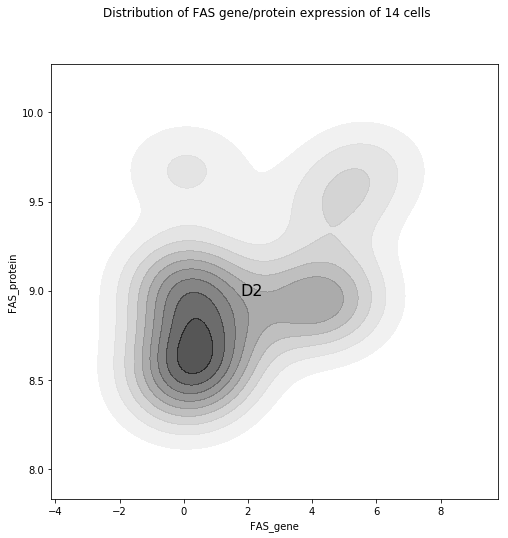

In [15]:
pg_scatter('FAS', clone='D2')

To compare two different clones, we overlay plots.

In [16]:
def pg_pair(pg,clonea, cloneb, ax=None):
    # Two subsets for the two clones.
    pg_df_a = pg_df[ pg_df['Clone_ID'] == clonea] 
    pg_df_b = pg_df[ pg_df['Clone_ID'] == cloneb]

    # Set up the figure
    f, ax = plt.subplots(figsize=(8, 8))
    
    # Draw the two density plots
    ax = sns.kdeplot(pg_df_a[pg+'_gene'], pg_df_a[pg+'_protein'],
                     cmap="Reds", shade=True, shade_lowest=False, alpha=0.7)
    ax = sns.kdeplot(pg_df_b[pg+'_gene'], pg_df_b[pg+'_protein'],
                     cmap="Blues", shade=True, shade_lowest=False, alpha=0.7)

    # Add labels to the plot
    red = sns.color_palette("Reds")[-2]
    blue = sns.color_palette("Blues")[-2]
    
    genemean_a = pg_df_a[pg+'_gene'].mean()
    genemean_b = pg_df_b[pg+'_gene'].mean()
    protmean_a = pg_df_a[pg+'_protein'].mean()
    protmean_b = pg_df_b[pg+'_protein'].mean()
    
    ax.text(genemean_a, protmean_a, clonea, size=16)
    ax.text(genemean_b, protmean_b, cloneb, size=16)
    f.suptitle('Comparison of {} protein/gene expression between {} and {}'.format(pg, clonea, cloneb))
    return ax

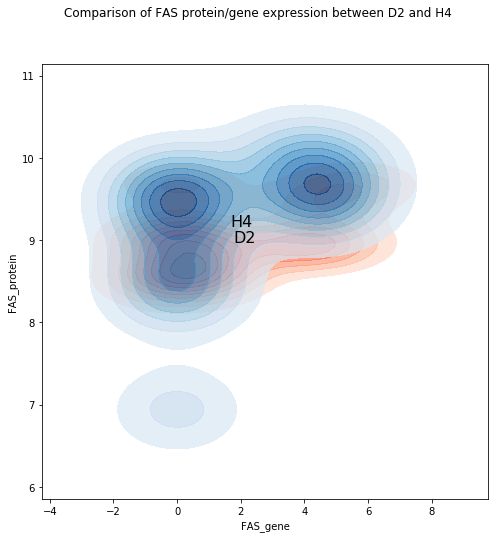

In [17]:
pg_pair('FAS','D2', 'H4')

Now we put together cells of the same clonotype, to compare statistics between clones.

In [18]:
def pg_compare(pg_list, ax=None, col_wrap = 5):
    serieslist = []
    for pg in pg_list:
        pg_df = pd.concat([EM[pg], prolog.loc[EM.index][pg]], axis=1)
        pg_df.columns = ['gene', 'protein'] # Separate headers for gene and protein.
        pg_df['Clone_ID'] = meta_df.loc[EM.index].Clone_ID # Add clonality information.
        pg_df_means = pg_df.groupby('Clone_ID').apply(lambda col : col.mean() )
        pg_df_means['protein and gene'] = pg
        serieslist.append(pg_df_means)
        
    df_means = pd.concat(serieslist, axis=0)
    
    sns.lmplot(x = 'gene', y = 'protein', data = df_means, col = 'protein and gene',
               sharex=False, sharey=False, truncate=True, height=3, ci=95, col_wrap = col_wrap)

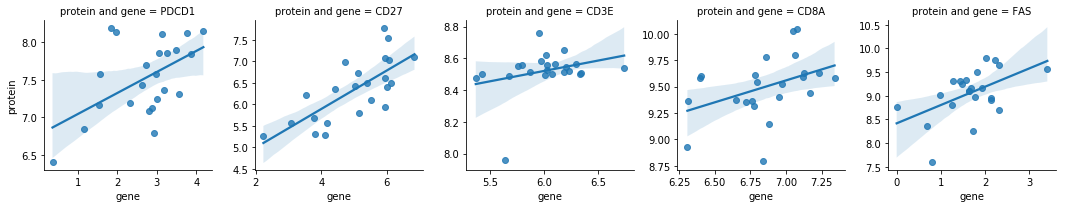

In [19]:
pg_compare(paired_proteins)

Here, each dot represents the mean gene expression and mean protein expression, for a given paired protein/gene and for all cells within a clonotype.  There is a positive correlation between mean gene expression and mean protein expression -- the shaded area is the 95% confidence interval, so we can be sure about the positive correlation in this experiment.

<a id='Signature'></a>
# 3.  Gene expression as a signature of clonality.

A central question is whether gene expression is a "signature" of clonality.  T-cells allow us to study this question because (1) the TCR genes certainly *do* provide a signature of clonality, so we *know* the clonotype of every cell, and (2) excluding the TCR genes, we can examine whether broad gene expression is a signature of this clonotype.  

We take a supervised machine learning approach to this question.  In this approach, a "signature" of clonality means that we can train the computer to predict clonality from gene expression.  We try three different machine learning approaches:

1.  A Bernoulli Naive Bayes (BNB) classifier, using binarized gene expression data.
2.  A Gaussian Naive Bayes (GNB) classifier, using genes which are very frequently expressed (above a cutoff).
3.  A Linear Support Vector (SVC) classifier, using genes selected by ANOVA F-statistic.

The approaches vary in their predictive accuracy, but all classifiers are far better than one would expect by chance.  They also go beyond what one might expect if the classifier was simply distinguishing cell types (e.g. memory vs. effector cells).  The Linear SVC classifier is most accurate, correctly predicting clonotype from gene expression about 95% of the time (using tuned parameters and a 80/20 training/testing split).

Each approach comes with a mode of feature selection and representation that carries additional information.  We study these along the way, to visualize the clonality signatures.

Using scikit-learn, the data is separated into an array `X` of gene expression (the "features") and an array `y` of clonalty (the "classes").  These will later be divided into training and validation sets.

In [21]:
X = EM.copy()  # The features.  Copied in memory, just in case.
y = meta_df.Clone_ID.loc[cells] # We are trying to predict clonality from the features.

For comparison to random assignment to clonotypes, i.e. a null hypothesis, we also produce a shuffled list of clonality.

In [22]:
yshuff = pd.Series(np.random.permutation(y.values), index=y.index)

We provide some general-purpose functions for visualizing the results of cross-validation, and for examining the "confusion matrix" of a classifier.

In [23]:
def CV_map(gs, swap=False):  # parameter_grid and grid_search.
    '''
    A general-purpose visualization for grid-search cross-validations.
    Displays predictive accuracy as a heatmap, based on different
    choices of parameters.  Displays optimal parameters in title.
    
    Args:
        gs (sklearn.model_selection.GridSearchCV):  The grid-search object.
        swap:  Set to True to switch the axes.
        
    Returns:
        None
        
    '''
    results = gs.cv_results_
    means = results['mean_test_score']
    params = list(gs.param_grid.keys())
    
    ser = pd.Series(list(means),
                  index=pd.MultiIndex.from_tuples(
                      [tuple(d.values()) for d in results['params']])
               )
    gs_df = ser.unstack().fillna(0)
    gs_df.shape 
    if swap:
        gs_df = gs_df.transpose()
        params = params[::-1] # Switch the order of the parameter list.
    
    f, ax = plt.subplots(figsize=(12,12))
    sns.heatmap(gs_df, annot=True, square=True, fmt="2.0%", linewidths=.5, 
                cbar_kws={'fraction':0.025, 'pad':0.05}, ax=ax)
    cbar = ax.collections[0].colorbar
    cbar.set_ticks([.5, .6, .7, .8, .9])
    cbar.set_ticklabels(['50%', '60%', '70%', '80%', '90%'])
    ax.set_xlabel(params[1])
    ax.set_ylabel(params[0])
    plt.yticks(rotation=0)
    bestacc = gs.best_score_
    ax.set_title("Result of grid-search with 5-fold cross-validation. \n"
                 "Best score {0:2.1%} with parameters \n"
                 "{1} ".format(gs.best_score_, gs.best_params_))

In [33]:
from sklearn import base

def confusion_matrix(X,y,pipe, reps=2, classlist = None):
    if classlist:
        classes = classlist
    else:
        classes = sorted(y.unique())
    counts = pd.DataFrame(0, index=classes, columns=classes)
    cpops = pd.DataFrame(0, index=classes, columns=['pop'])
    correct = 0
    total = 0
    for t in range(reps):
        this_pipe = base.clone(pipe)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
        this_pipe.fit(X_train, y_train)
        y_pred = this_pipe.predict(X_test)
        actual = y_test
        predicted = y_pred
        for j in range(len(y_test)):
            total += 1
            if y_test[j] == y_pred[j]:
                correct += 1
            cpops.loc[y_test[j],'pop'] += 1
            counts.loc[y_test[j], y_pred[j]] += 1
    
    valid = counts.apply(lambda column : column/cpops['pop']) #['pop'] )
    
    f, ax = plt.subplots(figsize=(12,10))
    sns.heatmap(valid, annot=valid, square=True, fmt="2.0%", linewidths=.5, 
                cbar_kws={'fraction':0.046, 'pad':0.04}, ax=ax)
    cbar = ax.collections[0].colorbar
    cbar.set_ticks([0, .25, .5, .75, 1])
    cbar.set_ticklabels(['0%', '25%', '50%', '75%', '100%'])
    ax.set_ylabel("Actual class")
    ax.set_xlabel("Predicted class")
    ax.set_title("Overall prediction accuracy {:0.3%}. \n"
                 "{} trials, in {} batches with independent splits.".format(correct/total, total, reps))

Each machine learning approach will be paired with a set of "significant" genes.  To visualize the expression of these genes, we provide a few general-purpose functions here.

In [25]:
def sort_by(df, col, valuelist):
    '''
    Sorts a data frame, according to the values in a column,
    and a chosen order for these values.
    '''
    if set(df[col].unique()) != set(valuelist):
        print('Warning, cannot sort!')
        return df
    value_dict = {valuelist[j]:j for j in range(len(valuelist))}
    df['newcol'] = df[col].apply(lambda v : value_dict[v])
    df.sort_values('newcol', inplace=True)
    df.drop('newcol', axis=1)
    return df

In [26]:
def vis_genebars(ef, mf, genelist, prop, classlist = None,z_score=True, binarize=False, 
                 cutoff = 1.0, num_genes = False, sort=True, genelabels = True, fitlabels = False):
    '''
    Visualizes gene expression across cells.
    
    Args:
        ef (pandas dataframe):  The gene expression matrix.
        mf (pandas dataframe:  The metadata dataframe.
        genelist (list): The list of genes to visualize.
        prop:  A column of the metadata, e.g. Clone_ID.  Place cells in blocks according to this.
        classlist:  Custom sort Clone_ID (or whatever prop) according to this list.
        z_score:  Plot z-scores for each gene.
        binarize:  Plot binarized data, e.g. whether a gene is on or off.
        cutoff:  The cutoff for binarization.
        num_genes:  Plot an extra row, for the total number of genes expressed.
        sort:  If True, sort and hierarchically cluster the genes.
        genelabels:  Label the rows by genes if True.
        fitlabels:  If True, extend the height of the image to fit in all the gene labels.
        
    Returns:
        None.  Just makes a pretty picture.
        
    
    '''
    genelist = [gene for gene in genelist if gene in ef.columns]
    df = ef[genelist].copy()
    
    if num_genes and binarize:
        print('Warning:  Number of genes and binarized expression cannot both be plotted by this function.')
    if num_genes:
        df['num_genes'] = (ef[genelist] > 1.0).sum(axis=1)
    if binarize:
        df = df > cutoff
    elif z_score:
        df = df.apply(zscore)
    df[prop] = mf[prop]
    if classlist:
        df = sort_by(df, prop, classlist)
    else:
        df.sort_values(prop, inplace=True)
    
    cells = df.index
    md = mf.loc[cells]
    classes = md[prop].unique()

    # Create plot.
    if fitlabels:
        figheight = len(genelist) // 4
    else:
        figheight = 12
    fig, axes = plt.subplots(2,1, sharex = True, figsize=(12, figheight), 
                             gridspec_kw = {'height_ratios':[0.25, 11.75], 'hspace':0.005})
    
    
    pal = sns.cubehelix_palette(len(classes),light=.9, dark=.1, reverse=True, start=1, rot=-2)
    lut = dict(zip(classes, pal))
    colors = pd.Series(df[prop]).map(lut)
    
    div_pal = sns.diverging_palette(220, 20, n=25)
    
    # Resort genes, based on hierarchical clustering and distance.
    if zscore:
        method,metric = 'average', 'euclidean'
    elif binarize:
        method,metric = 'complete', 'hamming'
    if sort:
        Y = sch.linkage(df[genelist].transpose(), method=method, metric=metric)
        genelist_sort = [genelist[j] for j in sch.leaves_list(Y)]
    else:
        genelist_sort = genelist
        
    if num_genes:
        genelist_sort = ['num_genes'] + genelist_sort 
    
    if binarize:
        sns.heatmap(df[genelist_sort].transpose(), cmap='magma', ax=axes[1], cbar = None)
    elif zscore:
        sns.heatmap(df[genelist_sort].transpose(), vmin=-3, vmax=3, cmap = div_pal, ax=axes[1], 
                    cbar_kws={"orientation": "horizontal", "fraction":0.025, "pad":0.025})
    

    axes[0].vlines(cells,0,0.05, colors = colors, linewidth = 12*72 / len(cells))

    for c in classes:
        mdp = md[md[prop] == c]
        midcell = mdp.index[len(mdp) // 2]
        axes[0].text(midcell, 0.065, c, horizontalalignment='center')

    axes[0].axis('off')
    axes[0].grid(False)

    axes[1].tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False) # labels along the bottom edge are off

    if genelabels:
        axes[1].tick_params(axis='y', rotation=0)
    else:
        axes[1].yaxis.set_ticklabels([])

    title = []
    title.append('Expression for {} genes.'.format(len(genelist)))
    if binarize:
        title.append('Binarized gene expression.')
    elif z_score:
        title.append('Color represents z-score.')
    fig.suptitle('\n '.join(title))
    plt.show()

In [27]:
def correlelogram(ef, genelist, binarize=False, z_score = True, cutoff = 1.0, num_genes = False):
    
    genelist = [gene for gene in genelist if gene in ef.columns]
    df = ef[genelist].copy()
    if num_genes and binarize:
        print('Warning:  Number of genes and binarized expression cannot both be plotted by this function.')
    if num_genes:
        df['num_genes'] = (ef[genelist] > cutoff).sum(axis=1)
    if binarize:
        df = df > cutoff
    elif z_score:
        df = df.apply(zscore)
    
    # Cluster and sort genes.
    if zscore:
        method,metric = 'average', 'euclidean'
    elif binarize:
        method,metric = 'complete', 'hamming'   
    Y = sch.linkage(df[genelist].transpose(), method=method, metric=metric)
    genelist_sort = [genelist[j] for j in sch.leaves_list(Y)]

    if num_genes:
        corr_matrix = df[['num_genes'] + genelist_sort].corr()
    else:
        corr_matrix = df[genelist_sort].corr()

    f, ax = plt.subplots(figsize=(18, 12))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    sns.heatmap(corr_matrix, cmap=cmap, vmax=1.0, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

    title = 'Correlations between expression of {} genes. \n'.format(len(genelist_sort))
    if binarize:
        title += 'Expression binarized with TPM cutoff {0:1.3f}.'.format(np.exp(cutoff)-1)
    elif z_score:
        title += 'Expression z-scores used for comparison.'
    f.suptitle(title)
    plt.show()

## 3.1  Machine learning via naive Bayes

scRNA gene expression data is complicated by dropouts (zeros) of biological and technical origin, some false-identifications (low expression counts which should be zero), and a generally complicated "real" distribution of gene expression in each cell.  A common model is ZINB (zero-inflated negative binomial), which is studied in [Risso et al.](https://www.nature.com/articles/s41467-017-02554-5), for example.

The ZINB model has three parameters (see Methods of loc. cit.), capturing dropout frequency and mean and dispersion (of the negative-binomial distribution).  Our Bayesian approach is a modification, which captures three closely related statistics:  the zero-frequency (zero = below a threshold hyperparameter) and the mean/std of the nonzero expressions.  This approach is computationally simpler (using existing tools) and separates phenomena which may have distinct biological origins.

Our Bayesian approach has two components: 

-  (Type B, for Binarized/Bernoulli) We binarize gene expression -- either a gene is expressed (above a threshold) or not.  We may use binarized gene expression to predict clonotype, choosing the most variable (binarized) genes by a $\chi^2$ statistic.  The hyperparameters are the threshold and the number of genes used for prediction.

- (Type G for Gaussian)  We consider only genes that are frequently expressed (e.g. >90% of cells express the gene).  We use differential expression of such genes to predict clonotype, choosing the most variably-expressed genes by an ANOVA F-statistic.  The hyperparameters are the number of frequently expressed genes in the first pool, and the number of differentially expressed genes used for prediction.

Along the way, we choose "significant" genes for prediction.  We study these genes, visualizing their expression profiles across clones.

### Type B:  The Bernoulli Naive Bayes Pipeline

We create a scikit-learn pipeline with three steps:  binarization, feature selection (selecting genes by a $\chi^2$-statistic), then using a Bernoulli Naive Bayes classifier.  Binarization turns all gene expressions into zeros or ones, depending on whether they reach a threshold. 

In [28]:
BNBpipe = make_pipeline(Binarizer(), SelectKBest(score_func = chi2), BernoulliNB())

To analyze the predictive power, we carry out 5-fold cross-validation on a grid of hyperparameters.  The first hyperparameter is the threshold for gene expression (for binarization).  The second is the number of genes (selected by $\chi^2$-statistic) used for prediction.

In [29]:
## DANGER DANGER.  Ignoring all warnings!
import warnings
warnings.filterwarnings("ignore")
##

param_grid = dict(binarizer__threshold=[0.01, 0.05, 0.5, 1.0, 2.0, 3.0, 4.0],
                  selectkbest__k = range(10,341,30),
                 )
grid_search = GridSearchCV(BNBpipe, param_grid=param_grid, cv=5, iid=False) #5-fold cross-validation.
grid_search.fit(X,y)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('binarizer', Binarizer(copy=True, threshold=0.0)), ('selectkbest', SelectKBest(k=10, score_func=<function chi2 at 0x1c21089488>)), ('bernoullinb', BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True))]),
       fit_params=None, iid=False, n_jobs=None,
       param_grid={'binarizer__threshold': [0.01, 0.05, 0.5, 1.0, 2.0, 3.0, 4.0], 'selectkbest__k': range(10, 341, 30)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

The following visualizes the results of cross-validation.

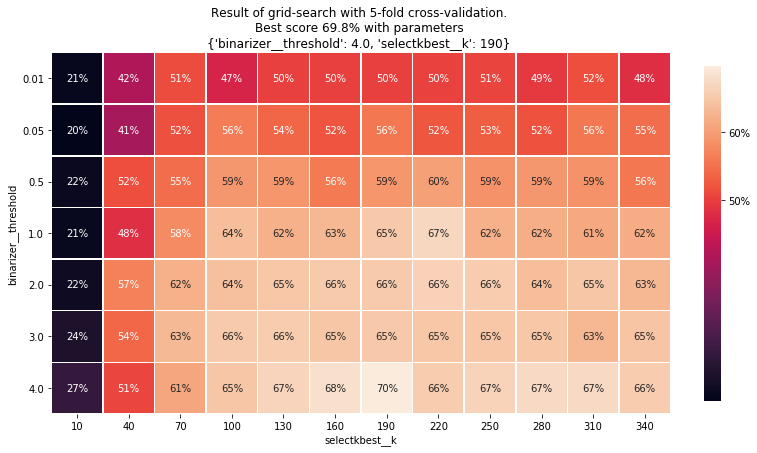

In [30]:
CV_map(grid_search)

We find that *binarized* gene expression data (whether a gene is expressed or not) yields a roughly 65% accurate predictor of clonotype, once hyperparameters are tuned (150-200 genes, with expression cutoff between 1.0 and 4.0).  The optimal hyperparameters are named below.

In [31]:
opt_threshold = grid_search.best_params_['binarizer__threshold']
opt_k = grid_search.best_params_['selectkbest__k']
print('Using tuned threshold {} and number of genes k={}'.format(opt_threshold, opt_k))

Using tuned threshold 4.0 and number of genes k=190


We run our Bernoulli Naive Bayes pipeline to study its predictions in more detail.  The data is divided into training and validation sets, in an 80%/20% ratio.  The classifier is trained on 80% and validated on 20%.  The "confusion matrix" displays the actual class (i.e., clonotype) and predicted class for each cell among the 20% in the validation set.

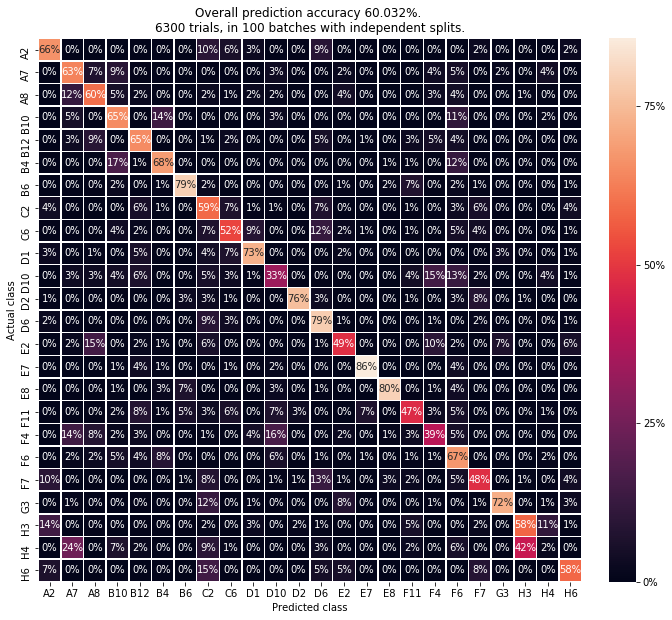

In [34]:
BNBpipe = make_pipeline(Binarizer(threshold=opt_threshold), 
                        SelectKBest(score_func = chi2, k=opt_k), 
                        BernoulliNB())

confusion_matrix(X,y,BNBpipe, reps=100, classlist = clones)

Next, we visualize binarized gene expression as a "barcode" of clonality.  We select the top 150 genes, by $\chi^2$ statistic after binarization.  Gene expression is binarized, so bars display whether or not a gene is expressed.  Genes are hierarchically clustered, using hamming-distance and the "complete method" described in the [SciPy documentation](https://docs.scipy.org/doc/scipy-1.0.0/reference/generated/scipy.cluster.hierarchy.linkage.html).  Cells are organized into clones, and clones are organized from EFF (first 5 color-bars) to MEM (next 2 color-bars) to MIX (last 2 color-bars).

The top 150 genes, selected by chi2 statistic after binarization, are ABLIM1, ACTN1, ADTRP, ALOX5AP, ANKFY1, ASAH2B, ASB2, ATP1B1, B4GALNT3, C10orf128, C19orf12, CADM1, CAPG, CAPN12, CCDC152, CCDC6, CCL23, CCR2, CD28, CD40LG, CD7, CDCP1, CENPU, CENPW, CKS1B, CLDN11, CLECL1, COL5A2, CPOX, CRACR2B, CRELD1, CSF2RB, CTSH, CTSL, EGFL6, ENPP6, ENTPD1, EOMES, EPAS1, FADS1, FAM49A, FAM50B, FHL1, FILIP1L, FLVCR2, FOXP3, FSTL4, GDF10, GLUL, GPAT3, GPR15, GPR183, GSTM4, GTSF1, HDAC9, HHEX, HLA-DMA, HLA-DPA1, HLA-DQB1, HLA-DRB5, HOXB2, HPGD, ID3, IFITM1, IFITM2, IGF2R, IGFBP3, ISG20, ITGAE, KIR2DL3, KIR2DL4, KIR3DL2, KIR3DL3, KLF10, KLRB1, KLRC1, KLRC2, KLRC3, KLRD1, LAIR2, LAT2, LETM2, LGALS3, LGMN, LILRB1, LMNA, LPAR6, LRRC28, MORC2, MSC, NBL1, NCF1, NT5C3B, NT5E, OTUD1, P2RX7, P2RY14, PDCD2L, PDE7B, PECAM1, PEX26, PGGHG, PIP5K1B, PLAU, PLS3, PMCH, POLR3A, PPP1R14B, PRSS23, PTGIS, RAMP1, RCBTB2, REG4, RGS16, RP11-277P12.6, RPL22L1, RPL39L, SAMD3, SCML4, SDC4, SELL, SEMA4A, SERINC5, SERPINE2, SLA

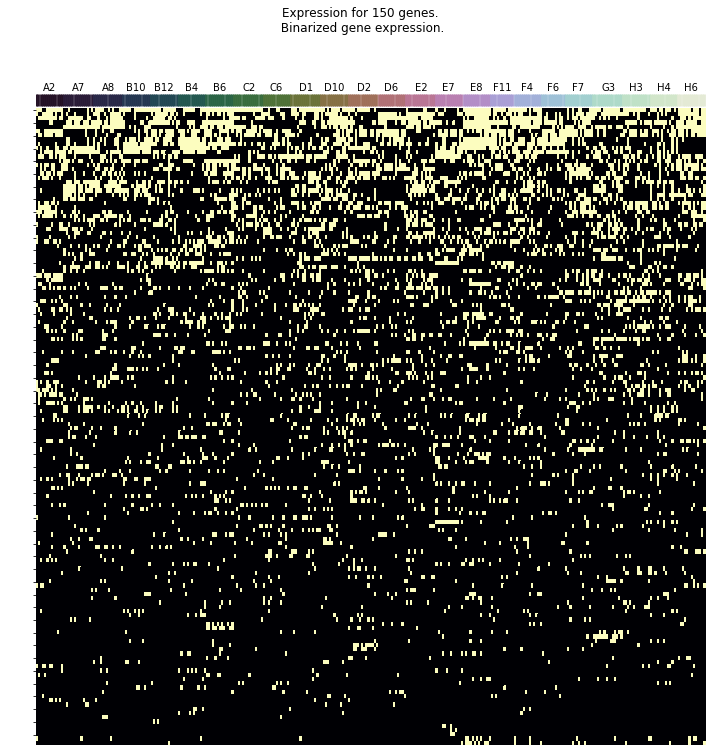

In [35]:
selector = make_pipeline(Binarizer(threshold=opt_threshold), 
                        SelectKBest(score_func = chi2, k=150))

selector.fit(X,y)
skb = selector.named_steps['selectkbest']
selected_genes = list(compress(genes, skb.get_support()))

print('The top 150 genes, selected by chi2 statistic after binarization, are {}.'.format(', '.join(selected_genes)))

df = EM[selected_genes].copy()
vis_genebars(df, meta_df, selected_genes, 'Clone_ID', binarize=True, genelabels=False,
             sort=True, cutoff = opt_threshold, classlist=clones)

For later use, we create a dataframe of genes, together with their $\chi^2$ statistic and associated p-value after binarization.  Genes with low p-value are those whose dropout frequency exhibits statistically significant variability between clones.

In [36]:
selector = make_pipeline(Binarizer(threshold=opt_threshold), 
                        SelectKBest(score_func = chi2, k='all'))

selector.fit(X,y)
skb = selector.named_steps['selectkbest']
selected_genes = list(compress(genes, skb.get_support()))

onoff_genes = pd.DataFrame(index=selected_genes, columns=['chi2', 'p_value'])
onoff_genes.chi2 = list(compress(skb.scores_, skb.get_support()))
onoff_genes.p_value = list(compress(skb.pvalues_, skb.get_support()))
onoff_genes.sort_values('p_value', inplace = True)

The ten most significant on/off genes are below.

In [37]:
display(onoff_genes[:10])

,chi2,p_value
KIR3DL2,200.150888,3.260501e-30
KIR2DL3,169.843611,2.262689e-24
REG4,153.513736,2.792570e-21
COL5A2,138.375740,1.849644e-18
KLRC1,130.959845,4.270706e-17
HPGD,113.958042,5.014889e-14
PLS3,106.051091,1.248307e-12
IGFBP3,99.692308,1.590967e-11
GPR15,95.791209,7.433742e-11
SELL,93.989698,1.506681e-10


In [38]:
print('There are {} genes, which exhibit statistically significant (p<0.01)  ' 
      'variability in dropout rate between clones.  In order of p-value, they are {}.'.format(
          len(onoff_genes[ onoff_genes.p_value < 1e-2]), 
          ', '.join(onoff_genes[ onoff_genes.p_value < 1e-2].index)
      ))

There are 165 genes, which exhibit statistically significant (p<0.01)  variability in dropout rate between clones.  In order of p-value, they are KIR3DL2, KIR2DL3, REG4, COL5A2, KLRC1, HPGD, PLS3, IGFBP3, GPR15, SELL, ITGAE, LAT2, KLRB1, LGMN, FOXP3, GTSF1, PDE7B, RP11-277P12.6, TIMD4, KLRC2, GPR183, EPAS1, KLRC3, FADS1, CAPG, KIR2DL4, FILIP1L, KIR3DL3, GDF10, ANKFY1, RCBTB2, IFITM1, EGFL6, CADM1, CLECL1, NCF1, LAIR2, PLAU, PMCH, SAMD3, KLRD1, CD28, ID3, LRRC28, HLA-DPA1, MSC, LILRB1, WIPF3, HOXB2, TP53INP1, TC2N, P2RY14, CCL23, CSF2RB, CCR2, ISG20, HLA-DRB5, TBCD, IFITM2, PECAM1, ALOX5AP, PPP1R14B, SLAMF7, NT5E, ADTRP, CCDC6, CTSL, TNFSF8, GLUL, ATP1B1, PTGIS, CD40LG, PIP5K1B, RAMP1, SLFN13, LPAR6, GPAT3, CENPU, RPL22L1, GSTM4, CTSH, ZBTB32, STRBP, SPOCK2, TXK, LGALS3, CAPN12, ABLIM1, RGS16, TSPAN13, FLVCR2, SPG20, FAM49A, TNFRSF13C, PEX26, ENTPD1, POLR3A, CDCP1, NT5C3B, SDC4, STARD3NL, PDCD2L, SCML4, STAP1, FAM50B, TTN, SERPINE2, UCHL1, TRIM56, FSTL4, TMTC3, NBL1, HLA-DQB1, ACTN1, PR

### Type G:  The Gaussian Naive Bayes Pipeline.

Now we carry out a similar analysis using a Gaussian Naive Bayes classifier.  The general purpose visualizers are the same as before.

The pipeline has three steps:

1.  Selecting only genes which are frequently expressed (above a TPM=10 threshold).
2.  From this pool, select the genes whose expression levels vary most between classes.
3.  Train the Gaussian Naive Bayes classifier on these selected genes.

Step 1 requires a custom scoring for frequency of expression.  Step 2 uses an ANOVA F-statistic for scoring (which is built in).

In [39]:
def express_score(X,y, threshold = 10):
    '''
    Scoring a gene based on frequency of expression.
    Default threshold is log-transform of a raw count of 10.  log(10+1) = 2.4
    '''
    return np.array((X>np.log1p(threshold)).sum(axis=0))

In [40]:
GNBpipe = Pipeline([ ('expr',SelectKBest(express_score, k=600)), 
                    ('fval',SelectKBest(f_classif, k=100)), 
                    ('gnb',GaussianNB()) ]) 

We carry out 5-fold cross-validation on a grid of hyperparameters.  The two hyperparameters are the number of genes in the pool of *frequently* expressed genes, and the number of genes in the subpool of *differentially* expressed genes.  These are called `expr__k` and `fval__k`, respectively.

In [41]:
param_grid = dict(expr__k = range(200,1001,50), fval__k = range(10,161,10))
grid_search = GridSearchCV(GNBpipe, param_grid=param_grid, cv=5, iid=False) #5-fold cross-validation.
grid_search.fit(X,y)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('expr', SelectKBest(k=600, score_func=<function express_score at 0x10d7ee1e0>)), ('fval', SelectKBest(k=100, score_func=<function f_classif at 0x1c21089378>)), ('gnb', GaussianNB(priors=None, var_smoothing=1e-09))]),
       fit_params=None, iid=False, n_jobs=None,
       param_grid={'expr__k': range(200, 1001, 50), 'fval__k': range(10, 161, 10)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

The results of cross-validation are displayed below, along with the optimal hyperparameters.

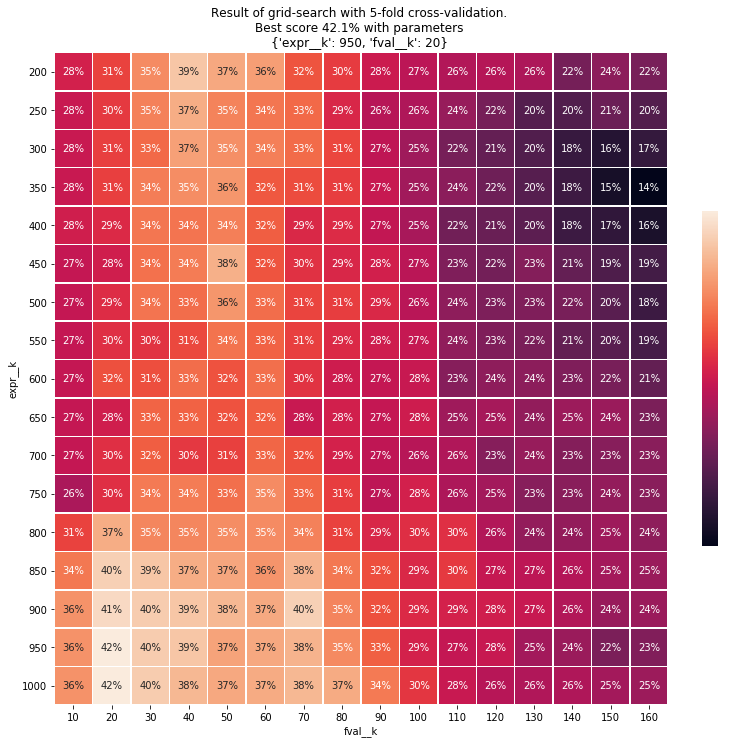

In [42]:
CV_map(grid_search)

The cross-validation indicates that it might be advantagous to keep more genes in the initial pool (selected by frequency of gene expression).  But in this circumstance, dropouts play a much larger role, and we wish to restrict our analysis to genes which are frequently expressed for now.  Thus we choose a non-optimal value (200) for `expr__k`, since we wish to limit our attention to the genes which are very frequently expressed.

We create a confusion matrix, to study the predictions in more detail. 

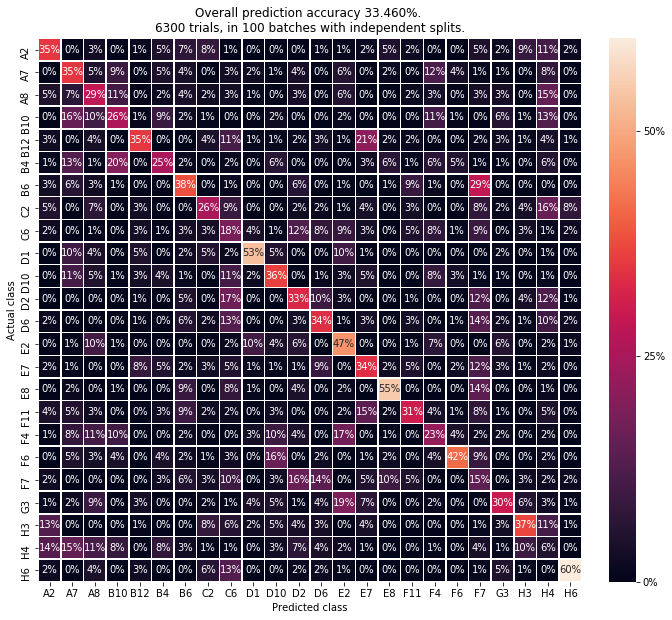

In [43]:
opt_expr__k = 200
opt_fval__k = 40
GNBpipe = Pipeline([ ('expr',SelectKBest(express_score, k=opt_expr__k)), 
                    ('fval',SelectKBest(f_classif, k=opt_fval__k)), 
                    ('gnb',GaussianNB()) ]) 

confusion_matrix(X,y,GNBpipe, reps=100, classlist = clones)

Now we select the 200 most frequently expressed genes for the starting pool, and then select the 50 most variably expressed genes (by ANOVA F-statistic) among the 200. We use the expression level of these 50 genes to produce a "gene expression barcode," to visualize this signature of clonality.

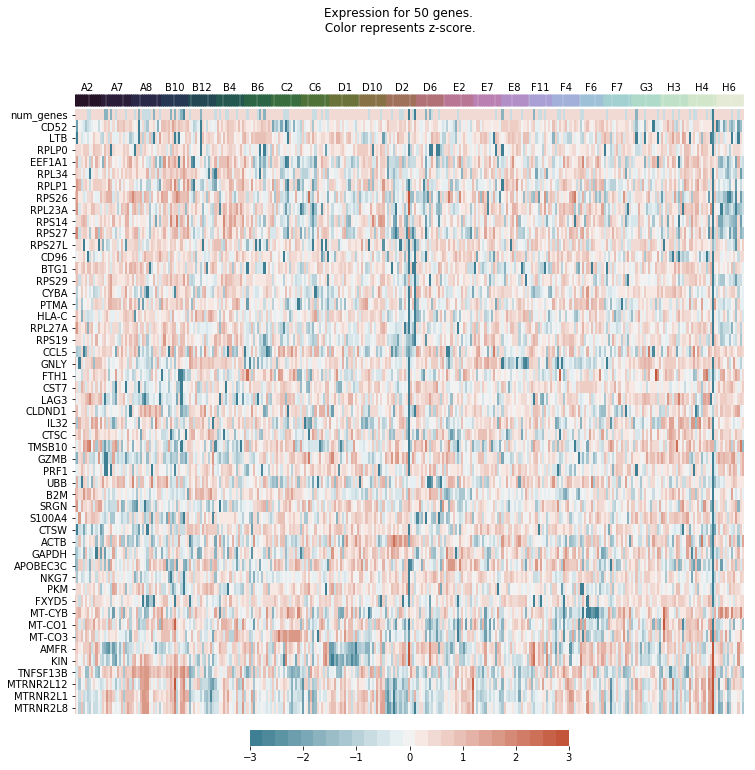

In [44]:
selector = Pipeline([ ('expr',SelectKBest(express_score, k=200)), 
                    ('fval',SelectKBest(f_classif, k=50))]) 

selector.fit_transform(X,y)
skbe = selector.named_steps['expr']
skbf = selector.named_steps['fval']

exp_genes = list(compress(genes, skbe.get_support())) # frequently expressed genes.
selected_genes = list(compress(exp_genes, skbf.get_support()))

df = EM[selected_genes].copy()
vis_genebars(df, meta_df, selected_genes, 'Clone_ID', sort=True, num_genes = True, classlist=clones)

For later use, we create a dataframe of "tunable" genes.  These are genes which are very *frequently* expressed, but whose expression level varies significantly between clones.

In [45]:
selector = Pipeline([ ('expr',SelectKBest(express_score, k=200)), 
                    ('fval',SelectKBest(f_classif, k='all'))]) 

selector.fit_transform(X,y)
skbe = selector.named_steps['expr']
skbf = selector.named_steps['fval']

exp_genes = list(compress(genes, skbe.get_support())) # frequently expressed genes.
selected_genes = list(compress(exp_genes, skbf.get_support()))

tunable_genes = pd.DataFrame(index=exp_genes, columns=['nonzero_ratio', 'p_value'])
tunable_genes.nonzero_ratio = list(compress(skbe.scores_, skbe.get_support())) 
tunable_genes = tunable_genes.loc[selected_genes]
tunable_genes.p_value = list(compress(skbf.pvalues_, skbf.get_support()))
tunable_genes.nonzero_ratio = tunable_genes.nonzero_ratio / np.float64(len(X))
tunable_genes.sort_values('p_value', inplace = True)
# Print the ten most significant genes.
display(tunable_genes[:10])

,nonzero_ratio,p_value
AMFR,1.000000,2.913221e-22
GNLY,0.977778,1.737125e-20
KIN,1.000000,2.157470e-19
TNFSF13B,1.000000,1.775437e-18
MT-CYB,1.000000,2.760499e-18
MTRNR2L1,1.000000,3.208462e-18
GZMB,0.990476,4.185936e-16
CD52,0.987302,4.299975e-15
MTRNR2L8,1.000000,7.622906e-15
LAG3,0.968254,3.054158e-10


In [46]:
print('We study {} frequently expressed genes.'.format(len(tunable_genes)))
print('Their maximum dropout rate is {0:2.1%}'.format(1 - tunable_genes.nonzero_ratio.min()))

We study 200 frequently expressed genes.
Their maximum dropout rate is 5.4%


In [47]:
print('Among these genes, {} vary significantly (p < 0.01) between clones.'.format(
    len(tunable_genes[ tunable_genes.p_value < 1e-2])))
print('These genes, ordered by p-value, are: {}'.format(', '.join(tunable_genes[ tunable_genes.p_value < 1e-2].index)))


Among these genes, 82 vary significantly (p < 0.01) between clones.
These genes, ordered by p-value, are: AMFR, GNLY, KIN, TNFSF13B, MT-CYB, MTRNR2L1, GZMB, CD52, MTRNR2L8, LAG3, APOBEC3C, CTSW, S100A4, RPS19, RPS26, RPL23A, RPL27A, B2M, PKM, MTRNR2L12, MT-CO1, MT-CO3, RPS27, CCL5, TMSB10, BTG1, CTSC, CD96, PTMA, CYBA, LTB, NKG7, CLDND1, CST7, HLA-C, RPS14, PRF1, UBB, SRGN, FTH1, IL32, GAPDH, RPLP1, RPL34, FXYD5, RPS27L, RPS29, RPLP0, EEF1A1, ACTB, CD74, CD3D, FTL, RPL18A, HNRNPH1, ID2, MT-ND2, MT-CO2, APOBEC3G, RPS3, HLA-B, RPL21, RPL13A, CD3G, ARPC2, ENO1, RPL41, GMFG, CD3E, TPI1, LPXN, MT-ND6, HCST, RPL15, RPL31, RPL3, MT-ND4, TMA7, STK17B, ARPC1B, RPS11, RPS18


 The clustering of genes exhibits some correlations in expression.  We create a correlation matrix below, and visualize gene-to-gene correlations in expression.  The number of genes is also included, so that we can see which higher-than-average gene expressions may be related to normalization issues.  For example, by carrying out TPM normalization at the beginning, those cells which express a large number of genes may have appear to have lower gene expressions (so that total expression per cell adds up to one million).
 
We focus here on the genes which exhibit significant variability at the $p < 10^{-6}$ level between clones.

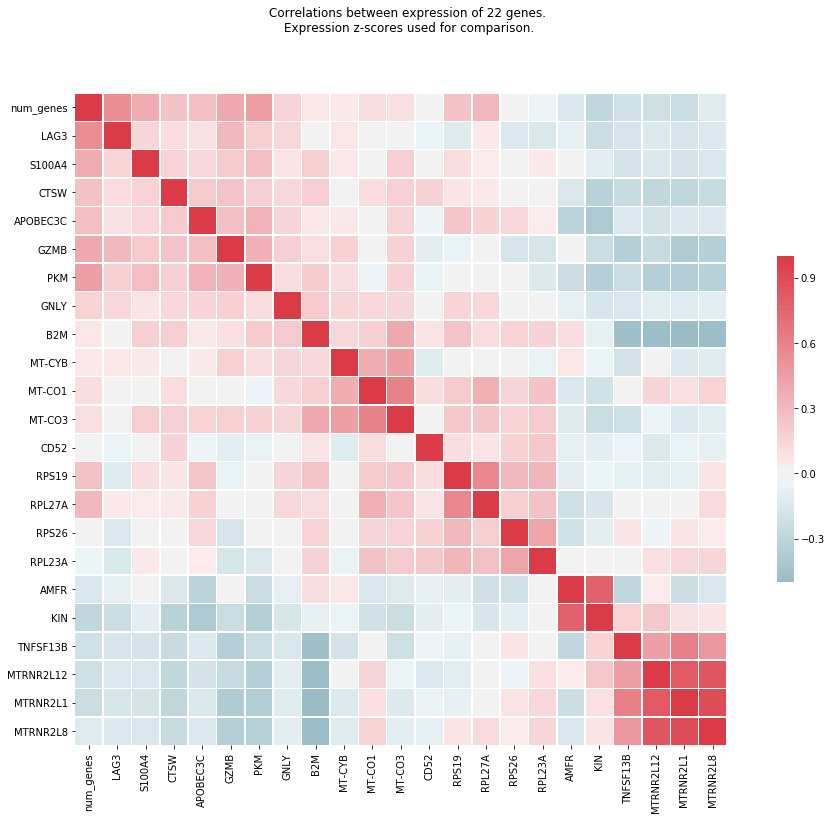

In [48]:
correlelogram(EM, tunable_genes[ tunable_genes.p_value < 1e-6].index, num_genes = True)

## 3.2:  Machine learning by linear SVM

Next, we take an entirely different approach to classification, using a soft-margin linear support vector classifier (SVC).  Support vector machines have been applied successfully in other genomic contexts -- see [Huang et al.](https://dx.doi.org/10.21873%2Fcgp.20063) for a survey in the context of cancer classification.  Our linear SVC pipeline has three steps.

1.  We pre-process the data by applying a linear function -- all gene-expressions will be shifted and scaled to lie between 0 and 1.  This is standard practice for linear SVM.

2.  We select the most variable genes by ANOVA F-statistic.  

3.  We apply the LinearSVC classifier and study the chosen genes.

4.  The LinearSVC classifier chooses weighted combinations of genes (we call these *metagenes*) that most effectively separate clones.  We study these weighted combinations in more detail and visualize them as signatures of clonality.

Regarding gene selection in step 2, we also attempted recursive feature elimination (RFE) with cross-validation.  This iteratively removes low-weighted genes from the metagenes, to select the genes most important for prediction.  While this might lead to improved classification with tuning, it did not make a big difference and it is computationally much more intensive.  On the other hand we do consider the weights of genes at the end, to better understand the selected metagenes.

We use 5-fold cross-validation and a grid search on the two most important hyperparameters.  These hyperparameters are the number of genes used in the classifier, and the C-parameter for the SVM.  In LinearSVC, the classifier tries to separate clonotypes by hyperplanes in gene-expression space.  Hyperplanes are scored by two criteria:

1.  Hyperplanes are considered better when the samples are farthest away from them (size of margin).

2.  Samples on the "wrong" side of the hyperplane count against the score, proportionally to how far on the wrong side they lie.  The C-parameter determines the penalty for these badly located samples, i.e., a higher C-parameter will be less tolerant of samples on the wrong side of the hyperplane.

In [49]:
#  DANGER DANGER!  The lines below ignore all warnings.
#  It's nice to avoid all the convergence warnings.  
#  But dangerous in general.
import warnings
warnings.filterwarnings("ignore")
#  End of warning.... proceed below.

SVM_pipe = Pipeline([ ('mm', MinMaxScaler()),
                     ('skb', SelectKBest(score_func = f_classif, k=110)),
                     ('svm', LinearSVC(random_state=0, tol=1e-4, C=1.0, max_iter=2000)) ])

param_grid = dict(skb__k = range(25,301,25), svm__C = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0])

grid_search = GridSearchCV(SVM_pipe, param_grid=param_grid, cv=5, iid=False) #5-fold cross-validation.
grid_search.fit(X,y)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('mm', MinMaxScaler(copy=True, feature_range=(0, 1))), ('skb', SelectKBest(k=110, score_func=<function f_classif at 0x1c21089378>)), ('svm', LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=2000,
     multi_class='ovr', penalty='l2', random_state=0, tol=0.0001,
     verbose=0))]),
       fit_params=None, iid=False, n_jobs=None,
       param_grid={'skb__k': range(25, 301, 25), 'svm__C': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

We visualize the cross-validation results as before.

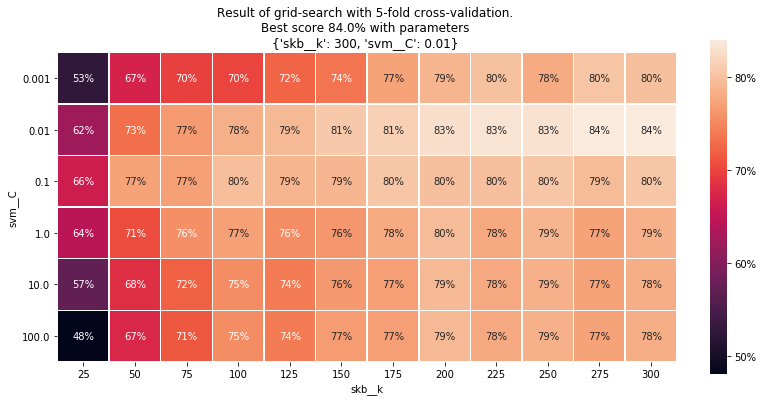

In [50]:
CV_map(grid_search, swap=True)

With minimal tuning, the SVM classifier (LinearSVC) exhibits better predictive accuracy than either of the Naive Bayes classifiers.  On the P3128 data, the SVM classifier achieves above 80% accuracy with 150-300 (or more) genes and a wide swath of C-parameters.  At least 150 genes seem necessary for achieving 80% accuracy in clonotype prediction.  Note that we have 24 clonotypes here, so 80% accuracy is pretty impressive!

Next, we look at the confusion matrix, with tuned paramaters.

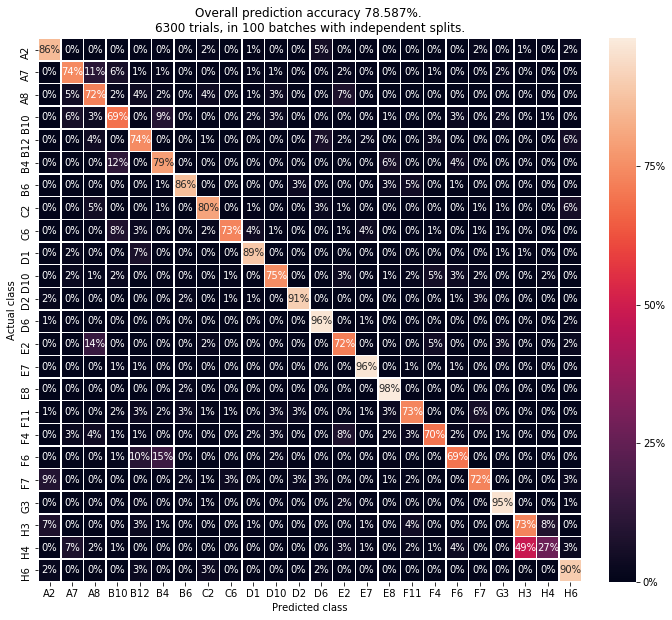

In [51]:
opt_skb__k = grid_search.best_params_['skb__k']
opt_svm__C = grid_search.best_params_['svm__C']

SVM_pipe = Pipeline([ ('mm', MinMaxScaler()),
                     ('skb', SelectKBest(score_func = f_classif, k=opt_skb__k)),
                     ('svm', LinearSVC(C = opt_svm__C)) ])

confusion_matrix(X,y,SVM_pipe, reps=100, classlist = clones)

### Examination of "metagenes"

The first step in our SVM pipeline is the selection of significant genes, based on ANOVA F-statistic.  Note that we don't do any other filtering -- frequency of expression is not separately accounted for.  All we are looking at is the variation of gene-expression means among groups... and zeros will certainly affect these means!  Also, we are applying the F-statistic on non-normally distributed data.  We leave it to the statisticians to decide whether this is naughty.

We look at the 50 most significant genes, selected by this process.  Then, the support vector classifier attempts to separate the clones by considering weighted averages of these genes.  We describe these weighted averages, and visualize them as a signature of clonality.

In [52]:
SVM_pipe = Pipeline([ ('mm', MinMaxScaler()),
                     ('skb', SelectKBest(score_func = f_classif, k=50)),
                     ('svm', LinearSVC(C = 0.1)) ])

SVM_pipe.fit(X,y)
skbf = SVM_pipe.named_steps['skb']
lsvc = SVM_pipe.named_steps['svm']

diff_genes = list(compress(genes, skbf.get_support())) # differentially-expressed genes by ANOVA F
print('The {} differentially expressed genes (selected by ANOVA F) are: {}'.format(len(diff_genes),', '.join(diff_genes)))

The 50 differentially expressed genes (selected by ANOVA F) are: ALOX5AP, AMFR, CAPG, CCR2, CD52, CD7, CD9, CLDN11, COL5A2, CSF1, CTLA4, ENTPD1, EPAS1, FOXP3, GNLY, GPR15, GZMA, GZMB, HLA-DPA1, HLA-DRB5, HOXB2, HPGD, IFITM1, IFITM2, IGFBP3, ITGAE, ITM2C, KIN, KIR2DL1, KIR2DL3, KIR3DL2, KIR3DL3, KLRB1, KLRC1, KLRC2, KLRC3, KLRD1, LAIR2, LAT2, MAL, MORC2, MT-CYB, MTRNR2L1, MTRNR2L8, PHLDA1, PLS3, REG4, RP11-277P12.6, SELL, TNFSF13B


In [53]:
def make_metagene(coef_list, g_list):
    '''
    Represents SVC coefficients as a metagene, including both coefficients and genes.
    Metagenes are represented as Python dictionaries, with keys=genes, values=coefficients.
    '''
    return dict(zip(g_list, coef_list))

The linear support vector machine creates certain linear combinations of gene expressions, which are then used to classify clones.  We call these linear combinations *meta-genes* and study them below.

In [54]:
metagenes = [ make_metagene(coef_list, diff_genes) for coef_list in lsvc.coef_ ]

In [55]:
def display_weighted(metagene, cutoff = 0.1):
    '''
    Displays a list of coefficients as a weighted average of gene expressions.
    Displays only those genes which contribute above a cutoff to the weighted average.
    '''
    term_list = []
    cno = 0
    for gene in metagene.keys():
        coef = metagene[gene]
        if abs(coef) > cutoff:
            if coef >= 0:
                if cno > 0:
                    sgn_mark = ' + '
                else:
                    sgn_mark = ''
            else:
                sgn_mark = ' - '
            term = '{0:} {1:0.3f} {2:}'.format(sgn_mark, abs(coef), gene)
            term_list.append(term)
            cno += 1
    return ''.join(term_list) + '... (+ terms with coefficient < {})'.format(cutoff)      

In [56]:
mg_no = 0
for metagene in metagenes:
    mg_no += 1
    print('METAGENE {}: '.format(mg_no), display_weighted(metagene))
    print('---------------------------')

METAGENE 1:   -  0.333 ALOX5AP +  0.233 CAPG -  0.164 CD52 -  0.295 CD7 -  0.158 CD9 -  0.292 CSF1 -  0.120 CTLA4 +  0.155 ENTPD1 +  0.217 EPAS1 +  0.380 FOXP3 +  0.446 GPR15 -  0.293 GZMA -  0.220 GZMB +  0.351 HLA-DPA1 -  0.238 IFITM1 -  0.233 IFITM2 -  0.118 ITGAE +  0.125 ITM2C -  0.437 KLRB1 -  0.141 KLRC2 -  0.116 KLRC3 +  0.188 KLRD1 -  0.258 LAT2 -  0.248 PLS3 +  0.133 SELL... (+ terms with coefficient < 0.1)
---------------------------
METAGENE 2:   -  0.195 AMFR +  0.362 CAPG -  0.149 CCR2 -  0.272 CLDN11 -  0.103 COL5A2 +  0.196 CSF1 -  0.474 ENTPD1 -  0.128 EPAS1 -  0.196 GPR15 -  0.466 GZMB +  0.102 HLA-DPA1 -  0.122 HLA-DRB5 -  0.178 HOXB2 -  0.100 IFITM1 -  0.370 IFITM2 +  0.187 ITGAE -  0.198 KIN -  0.204 KIR2DL1 -  0.269 KIR2DL3 -  0.246 KIR3DL2 -  0.137 KIR3DL3 +  0.296 KLRB1 +  0.256 KLRC2 +  0.237 KLRC3 +  0.130 KLRD1 +  0.236 LAIR2 -  0.120 MAL -  0.181 MORC2 -  0.159 MT-CYB -  0.396 PHLDA1 +  0.104 RP11-277P12.6 -  0.186 SELL... (+ terms with coefficient < 0.1)
--

Now, we turn this around, and examine the genes which contribute to the metagenes.  Each metagene is a weighted combination of (up to 50) genes.  We select the genes whose contribution is above a cutoff to some metagene.

In [57]:
def under_genes(mg_list, cutoff = 0.1):
    '''
    Gets the most significant genes appearing in a list of metagenes.
    Significance is determined by weight, according to a cutoff.
    '''
    ug_set = set([])
    for mg in mg_list:
        for gene in mg.keys():
            if abs(mg[gene]) > cutoff:
                ug_set.add(gene)
    return ug_set

In [58]:
print('The following genes underlie the metagenes: {}.'.format(', '.join(under_genes(metagenes)) ) )

The following genes underlie the metagenes: KIN, AMFR, HLA-DRB5, CCR2, CD52, GZMA, GNLY, MTRNR2L1, CD7, KLRB1, ALOX5AP, KIR3DL2, GPR15, REG4, MORC2, KIR2DL1, IFITM1, CSF1, SELL, GZMB, HOXB2, KIR2DL3, EPAS1, KLRC3, COL5A2, MT-CYB, CTLA4, CLDN11, FOXP3, PHLDA1, TNFSF13B, MTRNR2L8, IGFBP3, ITGAE, ENTPD1, MAL, HPGD, PLS3, LAT2, CAPG, IFITM2, ITM2C, KLRC1, HLA-DPA1, KLRD1, KIR3DL3, KLRC2, LAIR2, CD9, RP11-277P12.6.


Now we visualize the metagene-expression profile of our clones.  First, we create a dataframe with the metagene expression levels.

In [59]:
def add_metas(df, mg_list, mg_names='auto'):
    if type(mg_list) != list: # For adding single metagene.
        mg_list = [mg_list]
    mgname_list = []
    for j in range(len(mg_list)):
        if mg_names == 'auto':
            mg_name = 'Metagene {}'.format(j+1)
        else:
            mg_name = mg_names[j]
        mgname_list.append(mg_name)
        mg = mg_list[j]
        df[mg_name] = sum( (mg[gene]*df[gene] for gene in mg.keys() ))
    if mg_names == 'auto':
        return df, mgname_list
    else:
        return df

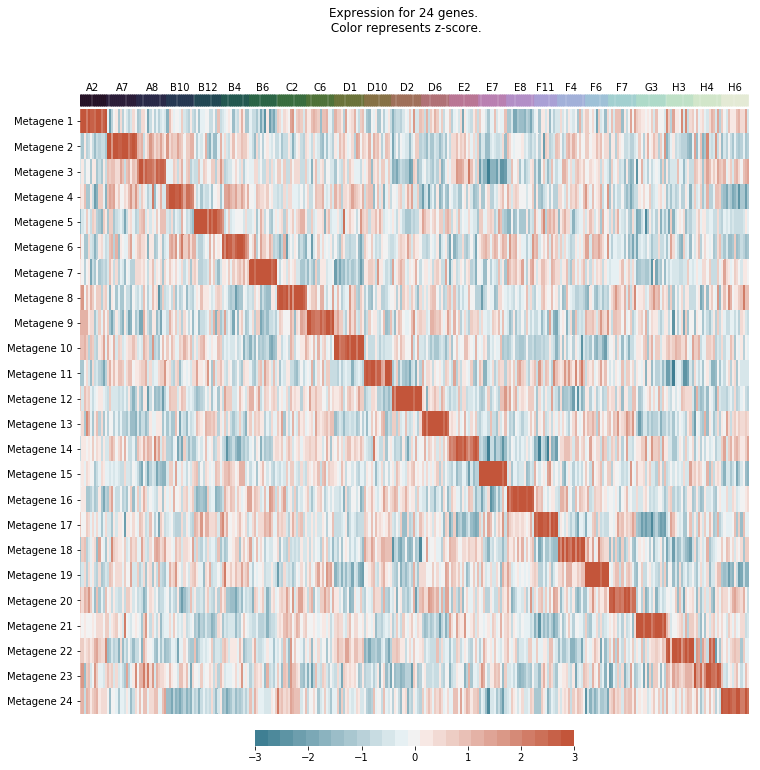

In [60]:
df = EM[diff_genes].copy()
df, metagene_list = add_metas(df, metagenes)
vis_genebars(df, meta_df, metagene_list, 'Clone_ID', sort=False)

In the figure above, we have used all of the cells in fitting the support vector classifier.  The resulting metagenes are overfitted as a result.  But separation into training/testing sets still leads to an excellent classifier.  The illustration above is meant to show *how* linear combinations of variably-expressed genes (our "metagenes") distinguish the clones.  And by fitting on all of the cells, the metagenes may carry better biological information.  The genes whose weights are the largest in the metagenes are those which are most significant for distinguishing clones.

Metagenes are also well-suited for scRNA data with a large proportion of dropouts.  By summming up contributions from many genes (with weights), the dropout-noise has a smaller effect without imputation.

For comparison, we make a similar plot, using the most significant (highly-weighted) genes occurring within the metagenes.

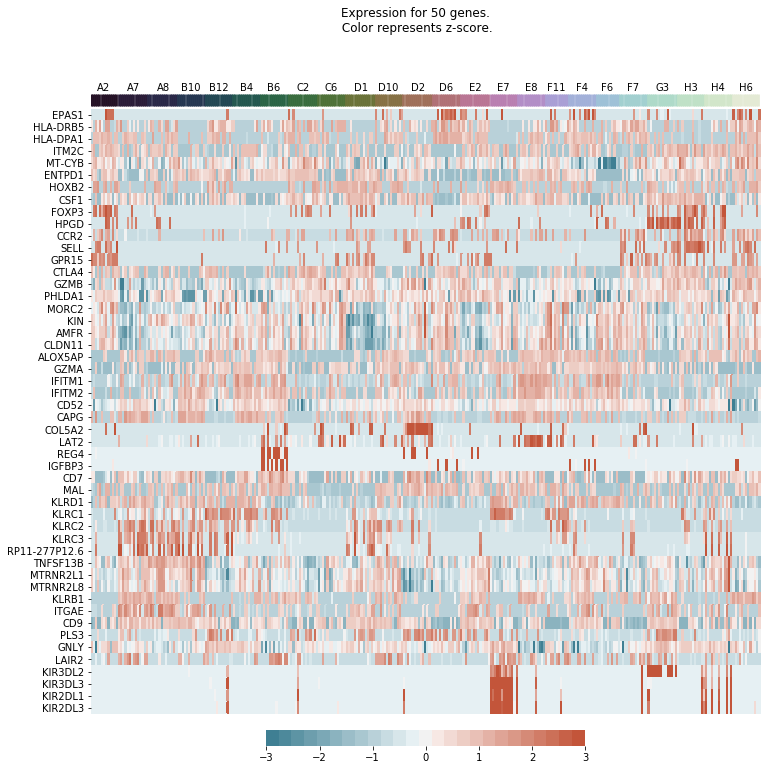

In [61]:
vis_genebars(EM, meta_df, list(under_genes(metagenes, cutoff=0.1)), 'Clone_ID')

Weighted combinations of these genes (the metagenes) do an excellent job of distinguishing clones, by "averaging out" the noise.  Still, one can see "blockiness" in the above picture, indicating the clonal specificity of the expression of these genes.  Some exhibit more binary behavior, and can be found in the earlier Bernoulli Naive Bayes approach.  Others are more "tunable" and can be found in the Gaussian Naive Bayes approach.

<a id='DGE'></a>
# 4.  Differential gene expression

Here we explore differential gene expression among clones, bewteen and within traditional EFF/MEM cell types.  We experiment with two basic approaches.  The first is parametric, based on the ANOVA F-statistic.  The second is nonparameteric, based on the Kruskal-Wallis H-statistic.  These statistics, F and H, are easy enough to compute, and have associated p-values.  The specific questions we have are the following:

1.  Is a gene XYZ expressed differently by different clones?
2.  If so, do the clonal differences in expression of XYZ primarily reflect the EFF/MEM status of the clone?
3.  Or, does the expression of XYZ distinguish one clone from all the others?

While the first question might be answered by F or H, the second and third require some deeper analyses.  If we answer the first question by the ANOVA F-statistic, it is natural to use Tukey HSD to answer the second and third.  If we answer the first question by the Kruskal-Wallis H-statistic, it is natural to use Dunn's test to answer the second and third.

We also try some more experimental approaches...

For more on differential expression analysis in scRNA data, see [Soneson and Robinson, Nature Methods volume 15, pages 255–261 (2018)](https://www.nature.com/articles/nmeth.4612).  They compare 36 approaches to identifying differentially expressed genes.  It would be interesting to apply our method to their data set to compare performance.  Since we haven't done a broad analysis, we take a conservative approach (i.e., using $p < 10^{-6}$ cutoffs in both parameteric and non-parameteric tests) to avoid Type I errors.  

Seurat, by default, uses the Wilcoxon ranked sum test for identifying differentially expressed genes, with the Bonferroni correction for multiple groups (I think).  Note that Kruskal-Wallis H is analogous to Wilcoxon, but designed for multiple groups (rather than corrected for them).  For practical purposes, our H-approach is the same as Seurat's default.

We import some more functions for this analysis.  This includes the new [scikit-posthocs package](https://github.com/maximtrp/scikit-posthocs).

In [62]:
import matplotlib.colors as pcolors
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import mpl_toolkits.axes_grid1.colorbar as colorbar
import scipy.stats as ss
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison

import scikit_posthocs as sp

### General purpose visualizations

In order to inspect a single gene's varying expression among the clones, the following function makes a swarm-plot, and gives the ANOVA F-statistic and Kruskal-Wallis H-statistic.

In [63]:
def swarm_gene(gene, clip = False):
    
    df = EM.copy()
    df['Clone_ID'] = meta_df.Clone_ID
    H = ss.kruskal(*[group[gene].values for name, group in df.groupby('Clone_ID')])
    F = ss.f_oneway(*[group[gene].values for name, group in df.groupby('Clone_ID')])
    df['num_genes'] = (EM[genes] > 2.4).sum(axis=1)
    
    df = df[[gene, 'Clone_ID', 'num_genes']]
    if clip:
        df = df[ df[gene] > 2.4 ] # Clip dropouts.
    df['z_genes'] = zscore(df['num_genes'])
    
    #create a figure
    fig,ax = plt.subplots(figsize=(9,6))
    
    # Apply a colormap.
    cmap = plt.get_cmap("viridis")
    norm = pcolors.Normalize(vmin=df['z_genes'].min(), vmax=df['z_genes'].max())    
    df['zc'] = df['z_genes'].apply(lambda cval : cmap(norm(cval)))
    
    # Create the swarmplot
    sns.swarmplot(x='Clone_ID', y=gene, data=df, hue = 'z_genes', 
                  palette=df['zc'], order=clones)
    
    ax.set_ylabel('Expression of {}, log-scale.'.format(gene))
    

    # Put the legend out of the figure
    plt.gca().legend_.remove()

    # create colorbar ##
    divider = make_axes_locatable(plt.gca())
    ax_cb = divider.new_horizontal(size="5%", pad=0.15)
    fig.add_axes(ax_cb)
    cb1 = colorbar.ColorbarBase(ax_cb, cmap=cmap, norm=norm, orientation='vertical')
    cb1.ax.set_ylabel('z-score of number of genes expressed')

    title_lines = ['Differential expression of {0} among clones.'.format(gene)]
    title_lines.append('Kruskal-Wallis H-statistic {0:3.3f}, p-value {1:1.3e}.'.format(H.statistic, H.pvalue))
    title_lines.append('ANOVA F-statistic {0:3.3f}, p-value {1:1.3e}.'.format(F.statistic, F.pvalue))
    fig.suptitle('\n '.join(title_lines))
    plt.show()

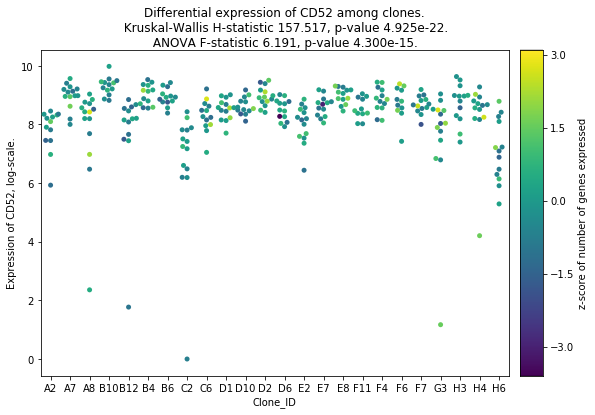

In [69]:
swarm_gene('CD52')

In this visualization of the differential expression of CD52, we see that A2 and C2 and H6 clones expresse the gene at lower levels than the other clones (with a few dropouts too).  Each dot stands for a cell, and the color indicates the total number of genes expressed by each cell.  We want to make sure that differential expression is not just due to total number of genes expressed (e.g., as an artifact of normalization).

### Non-parameteric approach, via Kruskal-Wallis

Our first function creates a data frame, the "KW-frame" whose rows are the clones and whose columns are the genes.  The entries are terms whose squares sum to the Kruskal-Wallis H-statistic.  Namely, if $h_{ij}$ is the entry for gene $i$ and clone $j$, then the Kruskal-Wallis H-statistic of gene $i$ is given by 
$$H = \sum_{j = 1}^g h_{ij}^2.$$
(Here $g$ is the number of clones.)  The entries of the KW-frame may be used later.

In [65]:
def KW_frame(gf, mf, prop = 'Clone_ID', genelist = None):
    if genelist:
        gf_rank = gf[genelist].rank()
    else:
        gf_rank = gf.rank()
    
    # Each column of gf_rank is a number between 1 and N.
    # N is the number of cells.
    N = len(gf_rank)
    meanrank = (1+N)/2 # Mean of all the ranks. 
    gf_rank[prop] = mf[prop] # Add the clonotype (or prop) to dataframe.
    pops = gf_rank[prop].value_counts() # Populations
    
    gf_rankmean = gf_rank.groupby(prop).apply(np.mean) # Compute mean ranks, the \bar r_i.
    
    ties = gf_rank.apply(lambda col : ss.tiecorrect(col))
    scaling = 12 / (ties * N*(N+1))
    H_frame = (gf_rankmean - meanrank).mul(np.sqrt(pops), axis=0)
    H_frame = H_frame * np.sqrt(scaling)
    return H_frame

In [66]:
EM_KW = KW_frame(EM, meta_df)
display(EM_KW)

,A1BG,AAAS,AAED1,AAGAB,AAK1,AAMDC,AAMP,AAR2,AARS,AARS2,...,ZSCAN32,ZSCAN9,ZSWIM7,ZSWIM8,ZUFSP,ZW10,ZWILCH,ZWINT,ZYX,ZZZ3
A2,0.441891,-1.971197,0.974474,-2.038697,0.840484,0.255813,-1.239018,-1.085067,-0.170423,-1.006226,...,0.351395,-0.911450,-0.791760,-1.519404,-0.506524,-0.531247,-0.521263,-0.013240,-1.896903,-0.889207
A7,-0.332669,0.695033,1.390933,0.239501,0.187805,0.011738,0.976029,-1.154367,-0.836760,-1.351552,...,-1.193827,0.174237,0.953699,-0.107933,0.157451,-1.440409,-1.803556,-0.082930,0.951717,2.052533
A8,2.528285,-0.758218,-0.179002,1.426051,1.226603,0.883319,1.341273,0.775426,-0.875861,-0.238335,...,1.163439,1.265883,1.076946,-1.576760,-1.359328,3.633645,0.014559,-0.121206,-0.199407,2.146525
B10,-1.645582,-0.606522,-1.108464,0.719636,2.746798,-1.778510,1.200796,0.589869,0.162308,1.242805,...,0.554123,0.265686,-0.578594,-0.092528,0.443889,-0.562497,-0.453273,-1.032730,1.523793,-0.839303
B12,-0.819339,-1.971197,0.995790,-1.041279,-0.715629,-1.303429,0.261181,0.284011,-0.710097,-0.554577,...,-0.198223,-0.911450,-1.525660,0.019480,-0.370361,-0.520830,1.813090,-1.032730,-2.059942,-0.419651
B4,-0.828545,1.147475,2.405732,0.055232,1.239409,0.027409,0.073258,0.775568,2.779522,0.823416,...,-0.306344,2.642098,-0.185759,-0.068178,-0.430273,-1.388013,2.045393,1.065830,0.749355,-0.920965
B6,5.132376,0.872900,-0.788715,-1.005541,-1.187640,0.666941,-2.837957,-0.156570,0.912982,1.026197,...,0.653234,1.524004,0.246664,-0.043829,-1.309881,-0.499997,1.008531,-1.032730,-0.034489,-0.979943
C2,-1.106679,-0.086879,0.537006,-0.010958,-2.441469,0.026412,-0.313066,-0.266662,-0.172044,-0.888205,...,-0.234424,-0.945856,-2.344631,-0.267486,-0.579945,-0.685073,0.132855,-0.114827,0.770438,0.225145
C6,-0.338323,1.270418,-0.578594,-0.276158,-1.266816,1.510515,0.286662,1.336308,0.616770,-1.089182,...,-1.000124,-0.911450,-0.191850,-1.519404,-0.392147,-1.388013,-1.153956,0.033100,-0.485983,0.968601
D1,0.388114,1.433505,-0.402021,1.936361,-1.593410,-0.959619,0.319205,-1.308751,0.758558,0.491473,...,2.231371,-0.945856,0.399086,-0.112626,0.320151,0.785450,-1.890912,-0.095689,0.157109,-0.393457


We use this to compute the Kruskal-Wallis H-statistics and associated p-values for every gene.

In [67]:
H = (EM_KW**2).sum(axis=0)
pvals =  ss.distributions.chi2.sf(H, len(clones) - 1)
H_frame = pd.DataFrame.from_dict({'H' : H, 'pvalue':pvals})
H_frame = H_frame.sort_values('pvalue') # Sort by p-value.
H_frame.head()

,H,pvalue
KLRB1,174.367907,3.094050e-25
KIR3DL2,164.052930,2.857419e-23
KLRC1,158.646118,3.015337e-22
CD52,157.516914,4.925222e-22
GNLY,154.576506,1.762909e-21


The most significantly (by H-statistic p-value) differentially expressed gene is KLRB1.  To examine it more closely, we look at the swarm plot.  This also gives a check that the H-statistic and p-value are correct (since they were computed by different methods).

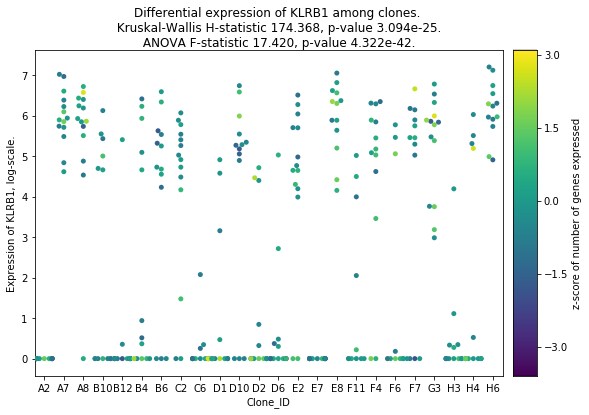

In [68]:
swarm_gene('KLRB1')

We say that a gene is H-DE, or *differentially expressed* according to H-statistic, if its p-value is below $10^{-6}$.  We choose this conservative cutoff, because even with $10^4$ genes, it would be unlikely to see such significant genes by chance.

To be more precise, there is a >99% chance of finding *zero* genes meeting the $p < 10^{-6}$ threshold in a random sample of genes of the size we're looking at (estimated below).  So if we *do* find such significant genes, we should pay attention to them.

In [70]:
print('{:1.3%}'.format( (1 - 1e-6)**len(H_frame) )) # Chance of finding no p<1e-6 genes, under null hypothesis.

99.158%


In [71]:
genes_H = H_frame[ H_frame.pvalue < 1e-6].index
print('There are {} H-DE genes'.format(len(genes_H)))

There are 154 H-DE genes


We visualize the expression of these H-DE genes, by z-score as before.  Note that there are too many genes to label, so labels in the figure may not align properly and many genes are unlabeled.

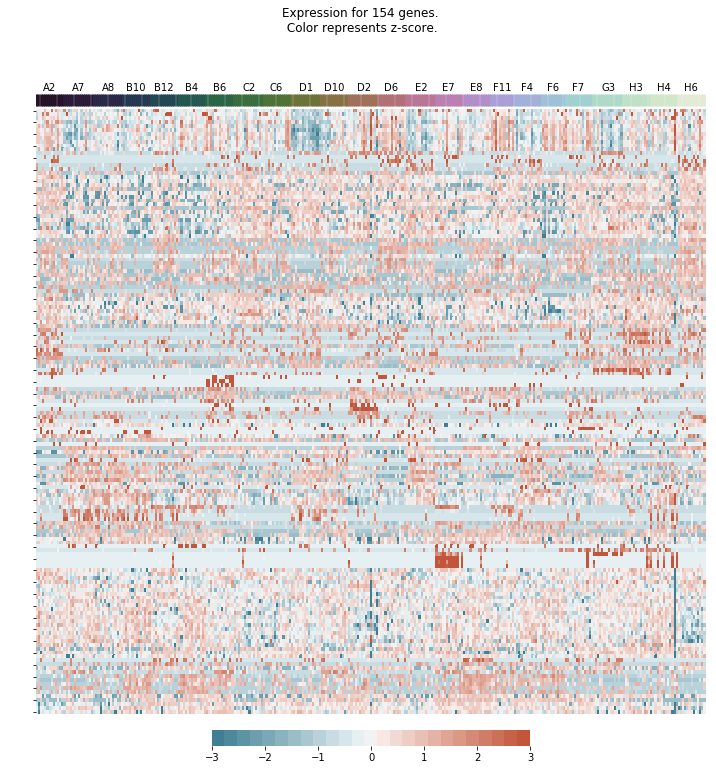

In [72]:
vis_genebars(EM, meta_df, genes_H, 'Clone_ID', genelabels = False)

In [73]:
print('The {} H-DE genes, in order of p-value, are: {}.'.format(len(genes_H), ', '.join(genes_H)))

The 154 H-DE genes, in order of p-value, are: KLRB1, KIR3DL2, KLRC1, CD52, GNLY, KIR2DL1, KIR3DL3, KIR2DL3, CD9, GZMA, HPGD, ALOX5AP, IFITM2, CSF1, REG4, COL5A2, KLRC2, ENTPD1, CAPG, AMFR, MTRNR2L1, GZMB, GPR15, IFITM1, TNFSF13B, CLDN11, SELL, B2M, HLA-DPA1, KLRD1, CCR2, ITGAE, KIN, CD70, ITM2C, MAL, IGFBP3, KLRC3, KIR2DL4, MORC2, PHLDA1, CTSW, RP11-277P12.6, HLA-DRB5, MTRNR2L8, CTLA4, LAG3, PMCH, EPAS1, KCNJ3, CLECL1, IFITM3, LPAR5, ITM2A, HOXB2, CD7, CST7, PPP1R14B, IL2RA, RPS19, HLA-DRB1, PARPBP, ASB2, SPOCK2, RPL27A, FOXP3, EGFL6, GZMH, PIAS2, ITGA1, RPS29, HLA-DMA, LTB, PLS3, LRRC28, FGF23, ANXA1, MT-CYB, RPL23A, PTMA, CD27, CACNA1A, MT-CO3, CTD-2545G14.7, LAIR2, PKM, CD40LG, RPL34, RPL21, CMTM6, SYNGR2, BPNT1, SOX4, IFNG, HLA-DPB1, CD59, TTC39C, HEPACAM, TNFRSF1B, CYBA, APOBEC3C, SNAP47, TBCD, TNFRSF18, TIMD4, AGBL5, HLA-DQB1, PLAU, FAM3C, TMSB10, S100A4, LIMK2, RDH10, TXK, CREM, HLA-C, F2R, IDH2, FXYD5, LDHA, PRF1, FTL, FKBP5, SPOCK1, RPS26, SMCO4, ISG15, CD74, C14orf105, RPLP1,

In [74]:
genes_H_notinnate = [gene for gene in genes_H if gene not in genes_innate]
print('The {} non-innate H-DE genes are: {}'.format(len(genes_H_notinnate), ', '.join(genes_H_notinnate)))

The 97 non-innate H-DE genes are: HPGD, ALOX5AP, IFITM2, REG4, COL5A2, CAPG, AMFR, MTRNR2L1, GPR15, CLDN11, KIN, ITM2C, MAL, IGFBP3, MORC2, PHLDA1, CTSW, RP11-277P12.6, MTRNR2L8, PMCH, EPAS1, KCNJ3, CLECL1, IFITM3, LPAR5, ITM2A, HOXB2, CST7, PPP1R14B, RPS19, HLA-DRB1, PARPBP, ASB2, SPOCK2, RPL27A, EGFL6, PIAS2, RPS29, PLS3, LRRC28, FGF23, ANXA1, MT-CYB, RPL23A, PTMA, CACNA1A, MT-CO3, CTD-2545G14.7, PKM, RPL34, RPL21, SYNGR2, BPNT1, SOX4, TTC39C, HEPACAM, APOBEC3C, SNAP47, TBCD, TIMD4, AGBL5, PLAU, FAM3C, TMSB10, S100A4, LIMK2, RDH10, TXK, CREM, F2R, IDH2, FXYD5, LDHA, FTL, FKBP5, SPOCK1, RPS26, SMCO4, ISG15, C14orf105, RPLP1, AOAH, UCP2, CPOX, JAML, LIN52, CTSC, CCL23, SRGN, RAMP1, SH3BGRL3, C10orf128, COTL1, NKG7, RPS27, MT-CO1, GDF10


For the genes that meet our strict $p < 10^{-6}$ threshold for H-significance, we can carry out a post-hoc analysis to identify the source of clonal differences.  This can also be seen from a swarm-plot, but a formulaic approach will be used later.  The Dunn test is a standard one for post-hoc analysis after Kruskal-Wallis, so that's what we use.  See [Dunn, Multiple Comparisons Using Rank Sums](https://www.jstor.org/stable/1266041) for more.

In [75]:
def dunn_chart(gf, mf, gene, prop='Clone_ID'):
    df = gf.copy()
    df[prop] = mf[prop]
    dunn_df = sp.posthoc_dunn(df, val_col = gene, group_col = prop, p_adjust='bonferroni')
    for clone in dunn_df.index:
        dunn_df.loc[clone, clone] = np.nan
    dunn_df = -np.log(dunn_df)
    fig,ax = plt.subplots(figsize=(5,5))
    sns.heatmap(dunn_df, square=True, ax=ax, cbar_kws={'fraction':0.046, 'pad':0.04})
    fig.suptitle('Dunn rank-sum multiple comparisons for {}. \n'
                 'Color displays -log(p value).'.format(gene))

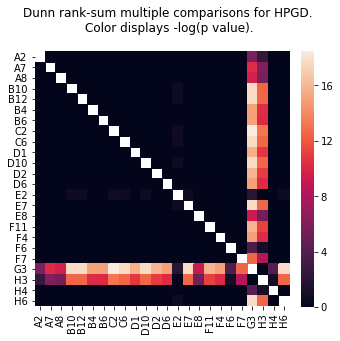

In [76]:
dunn_chart(EM, meta_df, 'HPGD')

The `dunn_chart` function provides the (Bonferroni-adjusted) p-values for each pair of clones.  For example, in the HPGD case pictured above, we find a p-value in the neighborhood of $10^{-5}$ when comparing G3 and H3 clones to many others.  One may interpret this as saying that REG4 distinguishes the clones G3 and H3 from the others.  This can also be seen on a swarm chart.

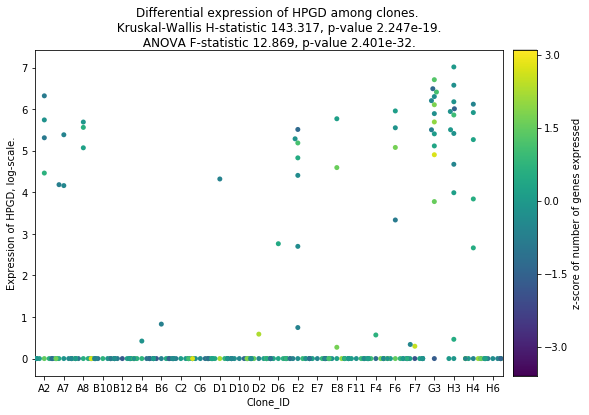

In [77]:
swarm_gene('HPGD')

We examine the Dunn chart for another gene below.

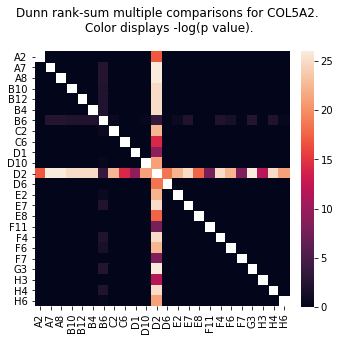

In [78]:
dunn_chart(EM, meta_df, 'COL5A2')

This gene isolates D2 clones from all others.  This can be seen in the swarm chart below.

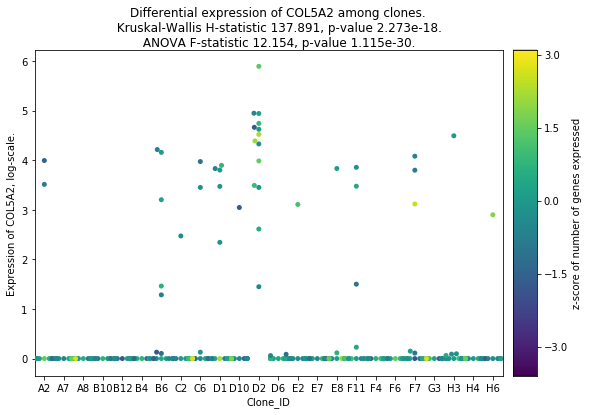

In [79]:
swarm_gene('COL5A2')

### Parametric approach via ANOVA F-statistic

Now we carry out a parametric analysis, in a similar manner.

In [80]:
def F_frame(gf, mf, prop = 'Clone_ID', genelist = None):
    if genelist:
        gfg = gf[genelist].copy()   
    else:
        gfg = gf.copy()
    
    N = len(gfg)  # N is the number of cells.
    all_mean = gfg.mean() # Mean of all the expression values. 
    gfg[prop] = mf[prop] # Add the clonotype (or prop) to dataframe.
    pops = gfg[prop].value_counts() # Populations
    K = len(pops) # K is the number of groups.
    scaling = (N-K) / (K-1)
    scaled = gfg.groupby(prop).apply(np.var).mul(pops, axis=0)
    scaling = scaling / scaled.sum()
    gf_means = gfg.groupby(prop).apply(np.mean) # Compute mean for each group, the \bar y_i.
    F_parts = (gf_means - all_mean).mul(np.sqrt(pops), axis=0)
    F_parts = F_parts * np.sqrt(scaling)
    return F_parts

In [81]:
EM_F = F_frame(EM, meta_df)
display(EM_F)

,A1BG,AAAS,AAED1,AAGAB,AAK1,AAMDC,AAMP,AAR2,AARS,AARS2,...,ZSCAN32,ZSCAN9,ZSWIM7,ZSWIM8,ZUFSP,ZW10,ZWILCH,ZWINT,ZYX,ZZZ3
A2,0.083870,-0.369417,0.097584,-0.355819,0.190953,0.175313,-0.185175,-0.098892,-0.069005,0.163566,...,-0.069890,-0.175665,-0.128256,-0.272695,-0.179138,-0.084523,-0.073824,-0.140565,-0.427775,-0.133359
A7,-0.043132,0.226559,0.248749,-0.075825,0.086959,-0.214378,0.221390,-0.283106,-0.110330,0.060379,...,-0.317787,0.072765,0.227730,0.056904,-0.182388,-0.289649,-0.289770,0.019877,0.291496,0.552265
A8,0.537580,-0.092745,-0.124110,0.230426,0.239485,0.063210,0.166871,0.047964,-0.116174,-0.226698,...,0.352699,0.234550,-0.048801,-0.282989,-0.244984,0.918141,0.027717,-0.165390,-0.028706,0.357115
B10,-0.338494,-0.082570,-0.253963,0.170627,0.561537,-0.137827,0.212520,0.201133,0.149156,0.018029,...,0.205470,0.091273,-0.004185,-0.155873,0.167046,-0.094891,-0.121729,-0.178062,0.248091,-0.112446
B12,-0.143875,-0.369417,0.286229,-0.200084,-0.198442,-0.132910,0.082282,-0.061127,-0.163021,-0.059731,...,0.025348,-0.175665,-0.278578,-0.023184,0.005545,-0.082810,0.083366,-0.178062,-0.488994,-0.188859
B4,-0.147771,0.100988,0.515305,-0.040768,0.256032,-0.094695,0.030343,-0.259922,0.601446,-0.040008,...,-0.000644,0.662315,-0.172076,-0.075080,-0.021916,-0.279113,-0.087262,0.136972,0.185001,-0.144701
B6,1.190855,0.260372,-0.114057,-0.249378,-0.273401,-0.054597,-0.657665,0.025368,-0.018036,-0.138212,...,0.227047,0.442107,0.114975,-0.072694,-0.236073,-0.077331,0.351004,-0.178062,0.070898,-0.162701
C2,-0.273532,0.045357,0.201738,-0.024585,-0.544131,0.221015,-0.116597,-0.246109,-0.036233,0.023671,...,0.028222,-0.182296,-0.374245,-0.266090,-0.159298,-0.125844,-0.205991,-0.165332,0.135218,-0.082924
C6,-0.086001,0.301889,-0.114836,-0.062328,-0.248907,0.218031,0.006138,0.306784,0.081646,0.071946,...,-0.155070,-0.175665,0.074050,-0.272695,-0.008494,-0.279113,-0.139581,0.088186,-0.084801,0.054374
D1,0.104214,0.172056,-0.092435,0.484908,-0.303928,-0.283672,0.073263,-0.142774,-0.013607,0.264252,...,0.432241,-0.182296,0.234313,-0.078755,0.161583,0.171858,-0.294316,-0.159580,0.051939,-0.033862


In [82]:
F = (EM_F**2).sum(axis=0)
pvals =  ss.f.sf(F, len(clones) - 1, len(EM) - len(clones))
F_frame = pd.DataFrame.from_dict({'F' : F, 'pvalue':pvals})
F_frame = F_frame.sort_values('pvalue') # Sort by p-value.
F_frame.head()

,F,pvalue
KIR3DL2,27.815387,4.426284e-60
KIR3DL3,25.115594,7.240815e-56
KLRB1,17.420056,4.321800e-42
KLRC1,17.268341,8.682570e-42
KIR2DL3,15.963305,4.014846e-39


The most significant gene, by F-statistic, is KIR3DL2.  It's swarm plot is below.

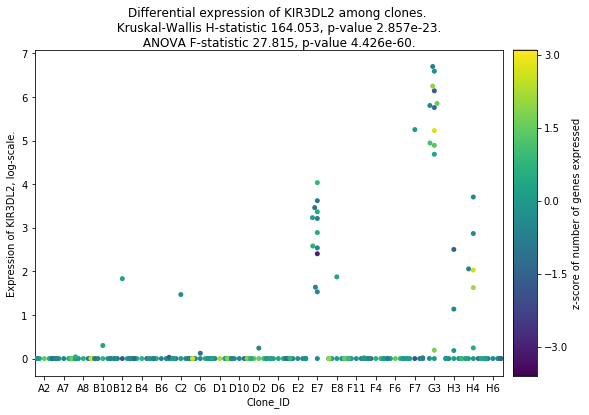

In [83]:
swarm_gene('KIR3DL2')

We select the genes which are differentially expressed according to the F-statistic below.  As for the H-statistic, we use the conservative $p < 10^{-6}$ cutoff.

In [84]:
genes_F = F_frame[ F_frame.pvalue < 1e-6].index
print('There are {} F-DE genes:  {}'.format(len(genes_F), ', '.join(genes_F)))

There are 146 F-DE genes:  KIR3DL2, KIR3DL3, KLRB1, KLRC1, KIR2DL3, KIR2DL1, REG4, HPGD, COL5A2, ENTPD1, ALOX5AP, CD9, CAPG, IFITM2, GPR15, PLS3, AMFR, CLDN11, KLRC2, GZMA, KLRC3, KLRD1, SELL, CSF1, GNLY, HLA-DPA1, IFITM1, KIN, IGFBP3, FOXP3, TNFSF13B, MT-CYB, MTRNR2L1, ITGAE, RP11-277P12.6, CCR2, GZMB, HLA-DRB5, LAT2, PHLDA1, MORC2, CTLA4, CD52, MTRNR2L8, ITM2C, HOXB2, MAL, EPAS1, LAIR2, CD7, LRRC28, PMCH, HLA-DMA, IFITM3, WIPF3, CLECL1, KIR2DL4, ASB2, PPP1R14B, CD70, TIMD4, GZMH, KCNJ3, HLA-DRB1, TBCD, SOX4, RCBTB2, SAMD3, SNAP47, EGFL6, IFNG, LAG3, CD40LG, RDH10, PTGIS, ITGA1, PDE7B, ANXA1, GTSF1, SYNGR2, GPR183, ITM2A, LGMN, APOBEC3C, TXK, CMTM6, CACNA1A, TTC39C, CD28, SPOCK2, PECAM1, CD59, CTSW, HEPACAM, F2R, CDCP1, CCL23, S100A4, LILRB1, C14orf105, FAM3C, FKBP5, MSC, RPS19, HLA-DPB1, LPAR6, TRIM22, TNFRSF18, RPS26, HLA-DQB1, PLAU, IDH2, FGF23, SMCO4, ISG20, LAYN, RPL23A, RPL27A, CXCR6, LDHA, LPAR5, CD27, RAMP1, GDF10, ID3, C10orf128, B2M, ZBTB32, CTSL, CADM1, GLUL, SDC4, SALL4, A

We visualize the expressions of these differentially expressed genes below.

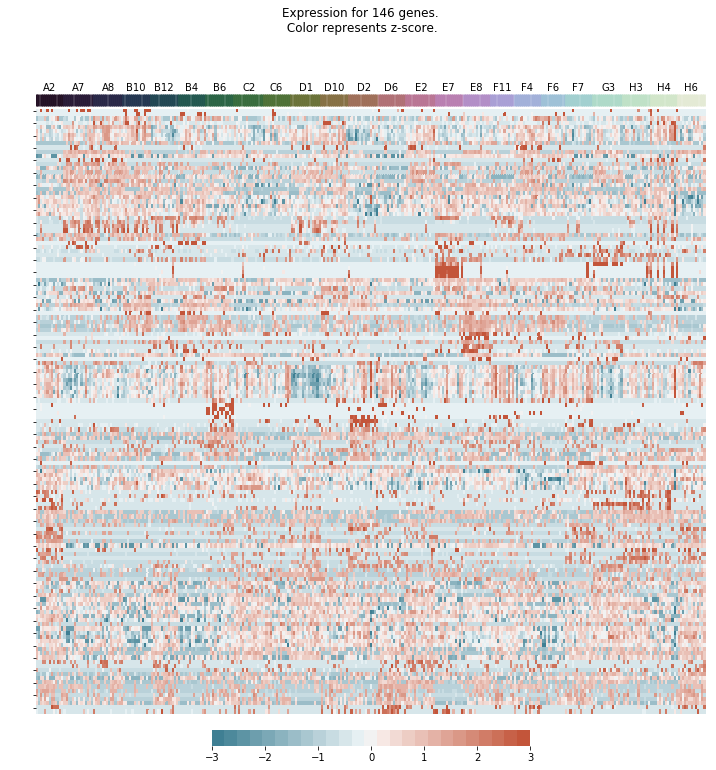

In [85]:
vis_genebars(EM, meta_df, genes_F, 'Clone_ID', genelabels = False)

### Comparison of parametric and nonparametric results

We compare the genes selected by F-statistic and those selected by H-statistic.

In [86]:
genes_FH = list(set(genes_F).intersection(genes_H))
print('The {} F-DE genes and {} H-DE genes intersect '
      'in {} FH-DE genes: {}.'.format(len(genes_F),len(genes_H),
                                      len(genes_FH),', '.join(genes_FH)))

The 146 F-DE genes and 154 H-DE genes intersect in 116 FH-DE genes: TNFRSF18, HLA-DRB5, CCR2, CD52, MTRNR2L1, KLRB1, F2R, HLA-DPB1, KIR2DL1, LAG3, CD40LG, HOXB2, HLA-DRB1, KIR2DL3, FKBP5, KLRC3, COL5A2, IFITM3, PHLDA1, TNFSF13B, TBCD, ENTPD1, MT-CO1, KCNJ3, KIR2DL4, KLRD1, HLA-DQB1, KIR3DL3, KLRC2, IDH2, GZMH, GZMA, PKM, SNAP47, ALOX5AP, RPL23A, CD27, MORC2, SELL, LDHA, HLA-DMA, CTSW, ANXA1, CLECL1, SPOCK2, B2M, CLDN11, C10orf128, COTL1, PPP1R14B, TIMD4, MAL, HPGD, TTC39C, PLS3, ASB2, GPR183, KLRC1, MT-CO3, TXK, APOBEC3C, MT-CYB, CD9, RP11-277P12.6, KIN, CD7, ITM2A, KIR3DL2, GPR15, PMCH, IFITM1, CD70, HEPACAM, ITGA1, CTLA4, SYNGR2, SOX4, IGFBP3, IFNG, CD59, RPS26, LPAR5, CMTM6, HLA-DPA1, KLRC4-KLRK1, AMFR, EGFL6, CREM, RPS19, GNLY, REG4, CSF1, CXCR6, GZMB, CACNA1A, C14orf105, EPAS1, PLAU, RPL27A, FGF23, FOXP3, MTRNR2L8, AOAH, CCL23, ITGAE, FAM3C, S100A4, RDH10, SMCO4, CAPG, IFITM2, ITM2C, LAIR2, GDF10, LRRC28, RAMP1.


In [87]:
genes_FH_noninnate = [gene for gene in genes_FH if gene not in genes_innate]
print('Among the {} FH-DE genes, {} are *not* innate.'.format(len(genes_FH), len(genes_FH_noninnate)) )
print('These non-innate differentially expressed genes are {}.'.format(', '.join(genes_FH_noninnate)))

Among the 116 FH-DE genes, 71 are *not* innate.
These non-innate differentially expressed genes are MTRNR2L1, F2R, HOXB2, HLA-DRB1, FKBP5, COL5A2, IFITM3, PHLDA1, TBCD, MT-CO1, KCNJ3, IDH2, PKM, SNAP47, ALOX5AP, RPL23A, MORC2, LDHA, CTSW, ANXA1, CLECL1, SPOCK2, CLDN11, C10orf128, COTL1, PPP1R14B, TIMD4, MAL, HPGD, TTC39C, PLS3, ASB2, MT-CO3, TXK, APOBEC3C, MT-CYB, RP11-277P12.6, KIN, ITM2A, GPR15, PMCH, HEPACAM, SYNGR2, SOX4, IGFBP3, RPS26, LPAR5, AMFR, EGFL6, CREM, RPS19, REG4, CACNA1A, C14orf105, EPAS1, PLAU, RPL27A, FGF23, MTRNR2L8, AOAH, CCL23, FAM3C, S100A4, RDH10, SMCO4, CAPG, IFITM2, ITM2C, GDF10, LRRC28, RAMP1.


In [88]:
FH_frame = pd.concat([F_frame, H_frame], axis=1)
FH_frame.columns = ['F', 'F_logpvalue', 'H', 'H_logpvalue']
FH_frame.F_logpvalue = -np.log(FH_frame.F_logpvalue) / np.log(10)
FH_frame.H_logpvalue = -np.log(FH_frame.H_logpvalue) / np.log(10)
FH_frame = FH_frame[ (FH_frame.F_logpvalue > 3) | (FH_frame.H_logpvalue > 3) ]
FH_frame.head()

,F,F_logpvalue,H,H_logpvalue
A1BG,2.392445,3.324969,47.833660,2.755233
ABLIM1,3.495549,6.457536,45.671535,2.483405
ACP5,2.470702,3.536809,50.969519,3.163490
ACTA2,2.839507,4.562323,57.983240,4.128694
ACTB,2.379148,3.289214,57.607479,4.075348


Here we examine the genes that are significant ($p < 10^{-6}$) with respect to one statistic but not significant ($p > 10^{-3}$) with respect to another.

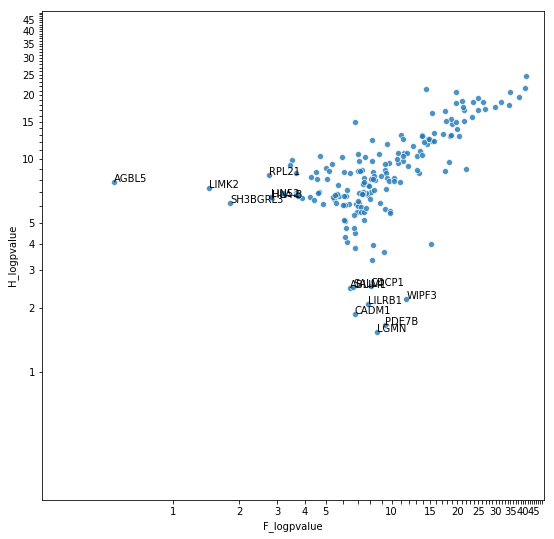

In [89]:
fix,ax = plt.subplots(figsize=(9,9))
FH_frame6 = FH_frame[ (FH_frame.F_logpvalue > 6) | (FH_frame.H_logpvalue > 6) ]
sns.scatterplot(x='F_logpvalue', y='H_logpvalue', 
                data=FH_frame6, alpha=0.8, ax=ax)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xbound(0.25,50)
ax.set_ybound(0.25,50)

ax.set_xticks(range(1,50))
ax.set_yticks(range(1,50))
ll = list(range(1,50))
for j in range(len(ll)):
    if (ll[j]%5 != 0) and (ll[j] > 5):
        ll[j] = ''
ax.set_xticklabels(ll)
ax.set_yticklabels(ll)
ax.minorticks_off()

for gene in FH_frame6.index:
    if (FH_frame6.loc[gene].F_logpvalue < 3) or (FH_frame6.loc[gene].H_logpvalue < 3):
        ax.text(FH_frame6.loc[gene].F_logpvalue, FH_frame6.loc[gene].H_logpvalue, gene)      



plt.show()

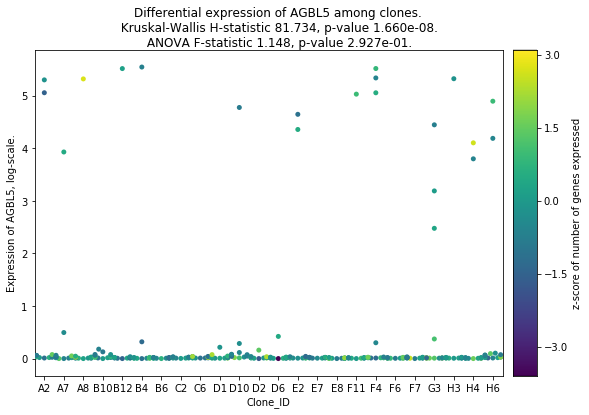

In [91]:
swarm_gene('AGBL5')

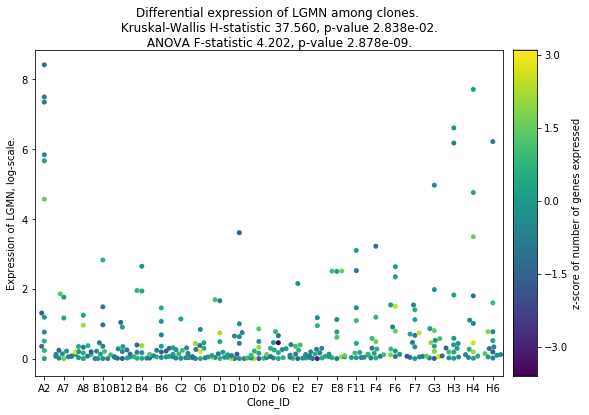

In [92]:
swarm_gene('LGMN')

It seems like some (like AGBL5 and LGMN) of the problematic genes (significant with respect to one statistic, insignificant for another) may be due to high droupouts.  This would yield numerous ties in the ranking which underlies the H-statistic, effectively a low population within clones, and large differences in variability between genes.  It might be a good idea to avoid genes which have very high overall dropout rate.  

Practically speaking, it might be best to take the intersection of the F-DE and H-DE genes to avoid such problems.  These are the genes stored in the list `genes_FH`.

In [93]:
print(genes_FH)

['TNFRSF18', 'HLA-DRB5', 'CCR2', 'CD52', 'MTRNR2L1', 'KLRB1', 'F2R', 'HLA-DPB1', 'KIR2DL1', 'LAG3', 'CD40LG', 'HOXB2', 'HLA-DRB1', 'KIR2DL3', 'FKBP5', 'KLRC3', 'COL5A2', 'IFITM3', 'PHLDA1', 'TNFSF13B', 'TBCD', 'ENTPD1', 'MT-CO1', 'KCNJ3', 'KIR2DL4', 'KLRD1', 'HLA-DQB1', 'KIR3DL3', 'KLRC2', 'IDH2', 'GZMH', 'GZMA', 'PKM', 'SNAP47', 'ALOX5AP', 'RPL23A', 'CD27', 'MORC2', 'SELL', 'LDHA', 'HLA-DMA', 'CTSW', 'ANXA1', 'CLECL1', 'SPOCK2', 'B2M', 'CLDN11', 'C10orf128', 'COTL1', 'PPP1R14B', 'TIMD4', 'MAL', 'HPGD', 'TTC39C', 'PLS3', 'ASB2', 'GPR183', 'KLRC1', 'MT-CO3', 'TXK', 'APOBEC3C', 'MT-CYB', 'CD9', 'RP11-277P12.6', 'KIN', 'CD7', 'ITM2A', 'KIR3DL2', 'GPR15', 'PMCH', 'IFITM1', 'CD70', 'HEPACAM', 'ITGA1', 'CTLA4', 'SYNGR2', 'SOX4', 'IGFBP3', 'IFNG', 'CD59', 'RPS26', 'LPAR5', 'CMTM6', 'HLA-DPA1', 'KLRC4-KLRK1', 'AMFR', 'EGFL6', 'CREM', 'RPS19', 'GNLY', 'REG4', 'CSF1', 'CXCR6', 'GZMB', 'CACNA1A', 'C14orf105', 'EPAS1', 'PLAU', 'RPL27A', 'FGF23', 'FOXP3', 'MTRNR2L8', 'AOAH', 'CCL23', 'ITGAE', 'FAM3

### Exploring clonal gene behaviors.

We capture gene behavior here by three statistics:  the nonzero ratio (100% minus the percentage of dropouts), the mean nonzero (mean of nonzero TPM values), and the variance nonzero (variance of the nonzero TPM values).  We produce a scatterplot of the genes in these three dimensions, with variance represented in color.

In [94]:
def dropmean(df, cutoff, genelist = None, absolute=True):
    if genelist:
        behave_df = df[genelist]
    else:
        behave_df = df.copy()
    no_cells = len(behave_df)
    max_expression = behave_df.max()
    if absolute:
        co = np.log1p(cutoff)
    else:
        co = cutoff
    behave_df = behave_df.clip(co,max(max_expression))
    dropout_df = behave_df.apply(lambda column: ((column > co).sum()) / no_cells )
    meannz_df = behave_df.apply(lambda column: column.replace(co, np.nan).mean())
    varnz_df = behave_df.apply(lambda column: column.replace(co, np.nan).var() )
    dm_df = pd.concat([dropout_df, meannz_df, varnz_df], axis=1)
    dm_df = dm_df.rename(columns={0: "Nonzero Ratio", 1: "Mean nonzero", 2:"Variance nonzero"})
    return dm_df

We create a dataframe with all (8000+) genes, their nonzero ratio, mean nonzero expression, and the variance of their nonzero expression.

In [95]:
dm_df = dropmean(EM, 10, genes)
dm_df.head()

,Nonzero Ratio,Mean nonzero,Variance nonzero
A1BG,0.149206,3.924499,0.401348
AAAS,0.187302,4.925303,0.414962
AAED1,0.301587,3.917430,0.678201
AAGAB,0.377778,4.828164,0.608960
AAK1,0.514286,3.340584,0.379951


We visualize this below, with variance portrayed by color.  Note that rarely-expressed genes have already been filtered out in preprocessing, as well as some often-lowly-expressed genes (bad libraries?). 

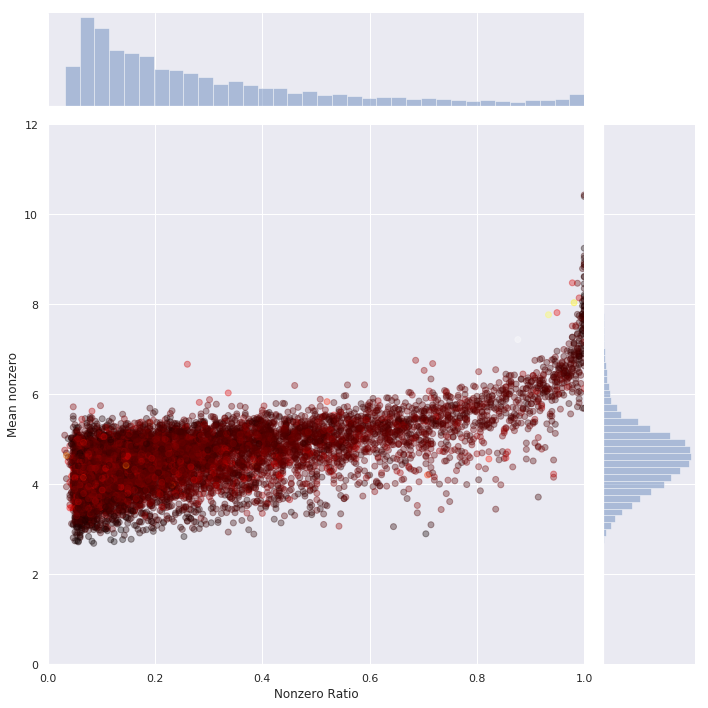

In [96]:
sns.set(style="darkgrid")

cmap = plt.get_cmap("hot")
norm = pcolors.Normalize(vmin=dm_df['Variance nonzero'].min(), vmax=dm_df['Variance nonzero'].max())    
colors = dm_df['Variance nonzero'].apply(lambda cval : cmap(norm(cval)))

fig = sns.jointplot(x=dm_df['Nonzero Ratio'], y=dm_df['Mean nonzero'],
                    alpha=.35, xlim=(0,1), ylim=(0,12), height=10,
                    joint_kws={"color":colors} )# Put the legend out of the figure

One way to understand the differential expression of genes is to consider how the statistics -- nonzero ratio, mean nonzero expression, and variance -- differ among the clones (for a fixed genes).  How do they "spread out" from the overall statistic.  First, we compute these statistics at the clonal level.

In [97]:
def dropmean_clones(df, mf, cutoff, genelist = None, absolute=True):
    if genelist:
        behave_df = df[genelist]
    else:
        behave_df = df.copy()
    no_cells = len(behave_df)
    max_expression = behave_df.max()
    if absolute:
        co = np.log1p(cutoff)
    else:
        co = cutoff
    behave_df = behave_df.clip(co,max(max_expression))
    allmeannz = behave_df.apply(lambda column: column.replace(co, np.nan).mean())
    
    behave_df['Clone_ID'] = mf['Clone_ID']
    
    dropout_df = behave_df.groupby('Clone_ID').apply(lambda column: ((column > co).sum()) / len(column) )
    meannz_df = behave_df.groupby('Clone_ID').apply(lambda column: column.replace(co, np.nan).mean())
    varnz_df = behave_df.groupby('Clone_ID').apply(lambda column: column.replace(co, np.nan).var() )
    dropout_df = dropout_df.fillna(0)
    dropout_df = dropout_df.drop('Clone_ID', axis=1) # How did that column get there anyways?
    meannz_df = meannz_df.fillna(allmeannz) # All dropouts -- set mean-nonzero to overall mean.
    varnz_df = varnz_df.fillna(0)
    return dropout_df, meannz_df, varnz_df

In [98]:
d_df, m_df, v_df = dropmean_clones(EM, meta_df, 10, genes_FH)

Next, we produce a visualization of the "spread" for each gene, and for lists of genes.

In [112]:
import matplotlib.lines as mlines

def spread_genes(genelist):
    sns.set(style="darkgrid")
    cmap = plt.get_cmap("hot")
    norm = pcolors.Normalize(vmin=dm_df['Variance nonzero'].min(), vmax=dm_df['Variance nonzero'].max())    
    colors = dm_df['Variance nonzero'].apply(lambda cval : cmap(norm(cval)))
    
    cols = min(len(genelist), 5)
    rows = (len(genelist) // 5)
    fig, axes = plt.subplots(rows, cols, figsize=(cols*3,rows*3), sharex = True, sharey = True)
    fig.suptitle('Overall and clonal behavior of {} genes'.format(len(genelist)))
    plotno = 0
    for gene in genelist:
        ax = axes[(plotno // 5), plotno%5]
        plotno += 1
        ax.set_xlim(0,1.05)
        #ax.set_xlabel('Nonzero ratio')
        #ax.set_ylabel('Mean nonzero')
        x_center = dm_df.loc[gene]['Nonzero Ratio']
        y_center = dm_df.loc[gene]['Mean nonzero']
        c_center = colors[gene]
        ax.set_ylim(- np.log(5), np.log(5) )
        foldlist = [np.log(n) for n in range(4,0,-1)] + [-np.log(n) for n in range(2,5)]
        foldlabels = ['1/4-fold', '1/3-fold', '1/2-fold', 'mean', '2-fold', '3-fold', '4-fold']
        ax.set_yticks(foldlist)
        ax.set_yticklabels(foldlabels[::-1])
        ax.plot(x_center, 0, marker='o', markersize=5, color=c_center)
        ax.set_title(gene)
        #ax.text(x_center, +0.2, gene)
        x_list = d_df[gene]
        y_list = m_df[gene] - y_center
        v_list = v_df[gene]
        #display(v_list)
        #c_list = cmap(norm(list(v_list.values)))
        for clone in clones:
            ax.plot([x_center, x_list[clone]], 
                     [0, y_list[clone]], 
                     color=cmap(norm(v_list[clone])))
            
            ax.plot(x_list[clone], y_list[clone], marker='$'+clone+'$', markersize=14, color=cmap(norm(v_list[clone])))
    
    plt.show()

In [113]:
def spread_gene(gene, nullhyp = True):
    sns.set(style="darkgrid")
    cmap = plt.get_cmap("hot")
    norm = pcolors.Normalize(vmin=dm_df['Variance nonzero'].min(), vmax=dm_df['Variance nonzero'].max())    
    colors = dm_df['Variance nonzero'].apply(lambda cval : cmap(norm(cval)))
    
    fig, ax = plt.subplots(figsize=(9,9))
    fig.suptitle('Overall and clonal behavior of {}'.format(gene))

    ax.set_xlabel('Nonzero ratio')
    ax.set_ylabel('Mean nonzero')
    x_center = dm_df.loc[gene]['Nonzero Ratio']
    y_center = dm_df.loc[gene]['Mean nonzero']
    c_center = colors[gene]
    ax.set_xlim(0,1.05)
    ax.set_ylim(- np.log(5), np.log(5) )
    foldlist = [np.log(n) for n in range(4,0,-1)] + [-np.log(n) for n in range(2,5)]
    foldlabels = ['1/4-fold', '1/3-fold', '1/2-fold', 'mean', '2-fold', '3-fold', '4-fold']
    ax.set_yticks(foldlist)
    ax.set_yticklabels(foldlabels[::-1])
    ax.plot(x_center, 0, marker='o', markersize=10) #, color=c_center)
    #ax.text(x_center, 0.2, gene)
    ax.set_title(gene)
    x_list = d_df[gene]
    y_list = m_df[gene] - y_center
    v_list = v_df[gene]
    for clone in clones:
        ax.plot([x_center, x_list[clone]], [0, y_list[clone]], color=cmap(norm(v_list[clone])))
                #marker=marker, markersize=20, 
                #color=cmap(norm(v_list[clone])))
        ax.plot(x_list[clone], y_list[clone], marker='$'+clone+'$', markersize=20, color=cmap(norm(v_list[clone])))
    
    plt.show()

Let's take a look at the differential expression of ANXA1.

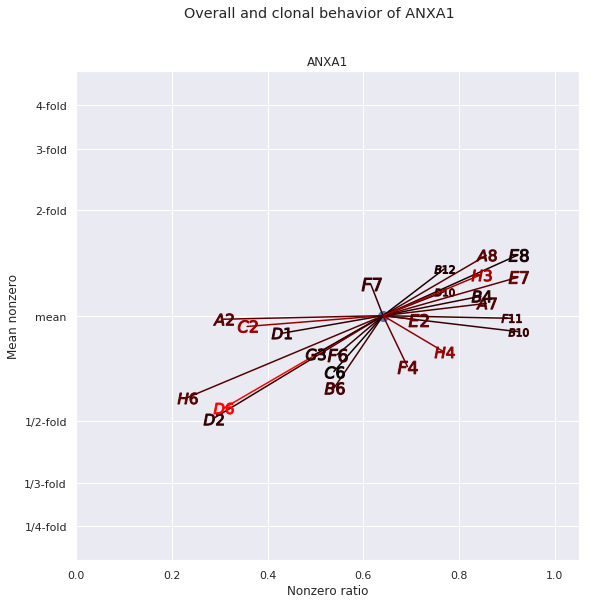

In [114]:
spread_gene('ANXA1')

We see a lot of "horizontal" spread, as B10, F11, E7, E8 clones almost always express ANXA1, while H6, D2, D6, A2 clones rarely express ANXA1 above the cutoff.  Moreover, there is a "vertical" spread too... while this probably shouldn't be interpreted for the rarely expressed clones (mean nonzero of a very small population!) B10 and E8 are vertically displaced.

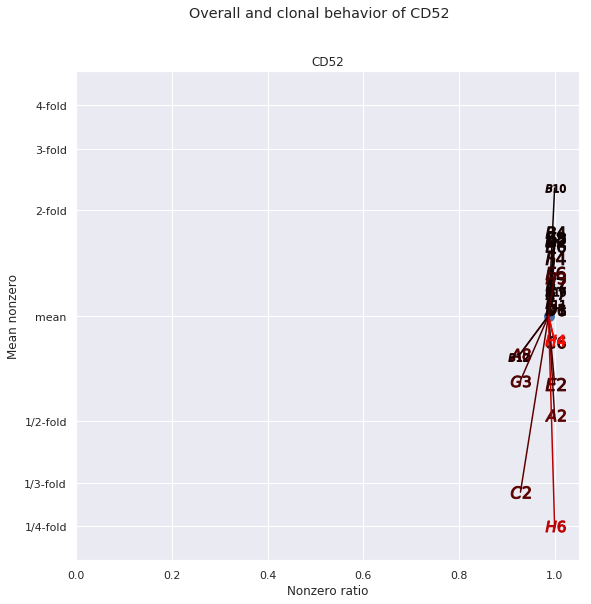

In [117]:
spread_gene('CD52')

The gene CD52 is almost always expressed, among all clones.  But there is a huge vertical spread, with more than an 8-fold difference between the highest-expressing clone B10 and the lowest, H6.

It may be useful to "zoom out" and see such snapshots for dozens of genes at once, to see the variety of behaviors.  That's what we do below.

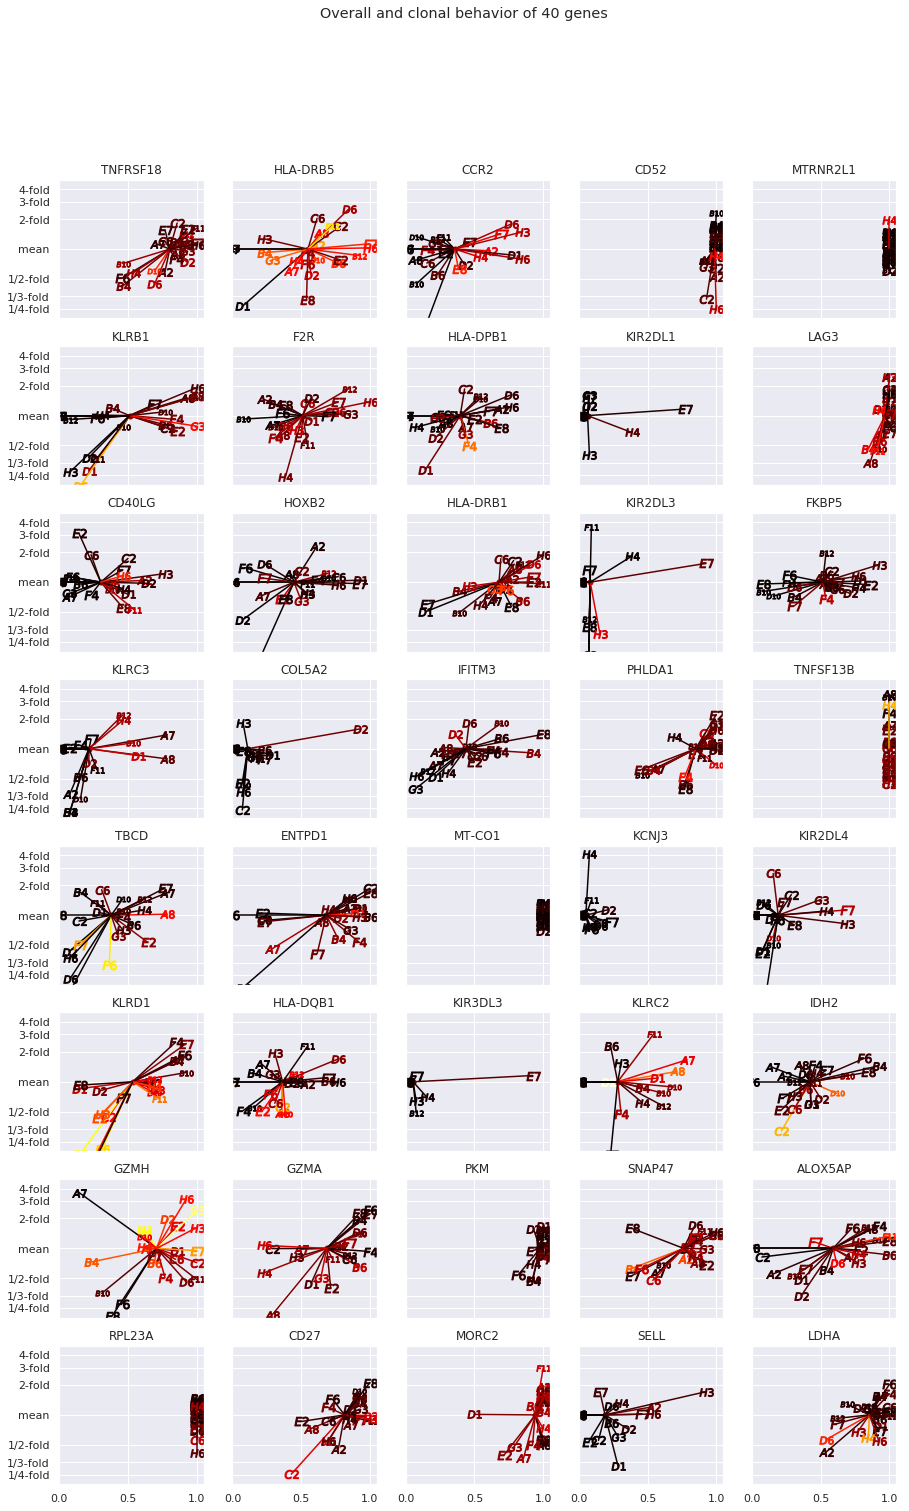

In [116]:
spread_genes(genes_FH[:40])

Can one find a correlation between these "shapes" of differential expression behavior and ATAC peaks?  Is there a correlation across experiments?

It's a bit hard to see whether these "spreads" are statistically significant, although the H and F statistics indicate significance at the $p < 10^{-6}$ level.  To visualize the significance, we overlay the results of a permutation test.  Namely, we randomly shuffle the clone-labels of cells (1000 times), and shade the plots with green dots where the randomly-produced spreads land.  This is computationally more intensive.

In [119]:
def perm_spread(gene, cutoff=10, absolute=True, num_iter = 1000):
    gene_exp = EM[gene]
    if absolute:
        co = np.log1p(cutoff)
    else:
        co = cutoff
    gene_exp.clip(lower=co, inplace=True)
    gene_meannz = gene_exp.replace(co, np.nan).mean()
    
    # Set up figure.
    fig, ax = plt.subplots(figsize=(6,5))
    fig.suptitle('Overall and clonal behavior of {}'.format(gene))
    ax.set_xlabel('Nonzero ratio')
    ax.set_ylabel('Mean nonzero')
    ax.set_xlim(0,1.05)
    ax.set_ylim(- np.log(5), np.log(5) )
    foldlist = [np.log(n) for n in range(4,0,-1)] + [-np.log(n) for n in range(2,5)]
    foldlabels = ['1/4-fold', '1/3-fold', '1/2-fold', 'mean', '2-fold', '3-fold', '4-fold']
    ax.set_yticks(foldlist)
    ax.set_yticklabels(foldlabels[::-1])
    
    # Plot center point
    x_center = (gene_exp > co).sum() / len(gene_exp)
    y_center = gene_meannz
    ax.plot(x_center, 0, marker='o', markersize=10) #, color=c_center)
    
    xlist = np.zeros((num_iter, len(clones)))
    ylist = np.zeros((num_iter, len(clones)))
    
    # Data frame of permuted cells.
    rand_df = pd.DataFrame(0, index=EM.index, columns=np.arange(num_iter))
    rand_df = rand_df.apply(lambda column : np.random.permutation(gene_exp))
    rand_df['Clone_ID'] = meta_df['Clone_ID']
    rand_df[gene] = gene_exp
    
    # Compute dropout ratio and mean nonzero.
    dropout_df = rand_df.groupby('Clone_ID').apply(lambda column: ((column > co).sum()) / len(column) )
    meannz_df = rand_df.groupby('Clone_ID').apply(lambda column: column.replace(co, np.nan).mean())
    dropout_df = dropout_df.fillna(0)
    dropout_df = dropout_df.drop('Clone_ID', axis=1) # How did that column get there anyways?
    meannz_df = meannz_df.fillna(gene_meannz) # All dropouts -- set mean-nonzero to overall mean.
    meannz_df = meannz_df - gene_meannz # Shift by overall mean

    # Show null hypothesis expectations 
    sns.kdeplot(dropout_df.drop(gene, axis=1).values.flatten(), meannz_df.drop(gene, axis=1).values.flatten(), 
                ax=ax, cbar=True, shade=True, shade_lowest = False, cmap="Greens")
    
    
    x_list = dropout_df[gene]
    y_list = meannz_df[gene]
    for clone in clones:
        ax.plot([x_center, x_list[clone]], [0, y_list[clone]], color='k')
        ax.plot(x_list[clone], y_list[clone], marker='$'+clone+'$', markersize=20, color='k')
    
    
    plt.show()

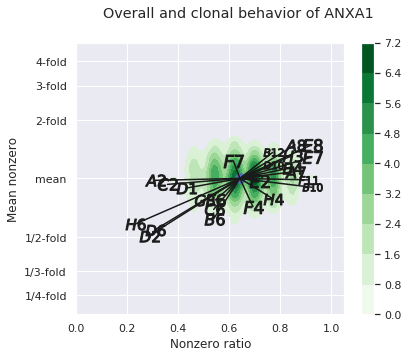

In [120]:
perm_spread('ANXA1')

The null hypothesis predicts the clones to all lie within the green blob (based on 1000 random permutations of clone-labels).  This gives us an indication of how significant this spread is.  Here are a few more examples.

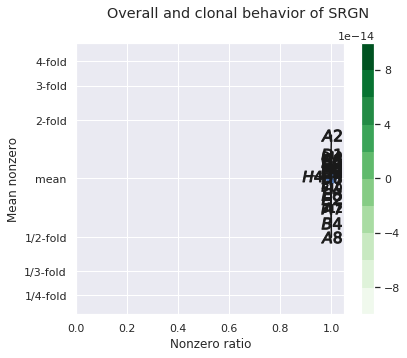

In [121]:
perm_spread('SRGN')

For genes like SRGN which are almost always expresed, the "green blob" of the null hypothesis is exceedingly small.  The roughly 4-fold difference in expression levels between the highest-expressed clone A2 and the lowest, A8, is significant.

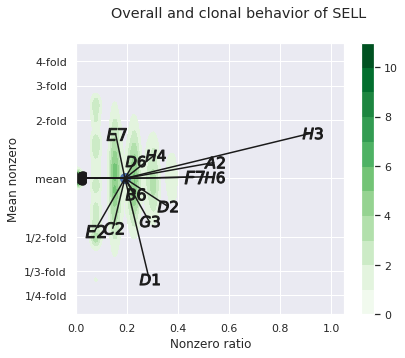

In [122]:
perm_spread('SELL')

For SELL, the green blob is fairly broad, since the nonzero ratio is small but nonzero.  Still, the outliers H3, A2, H6 exceed reasonable thresholds for statistical significance.  They lie far outside the blob obtained by 1000 random permutations of clone-labels.

## Exporting the differentially expressed genes

We have identified genes as differentially expressed based on ANOVA F statistic and Kruskal-Wallis H statistic.  The *way* in which genes are differentially expressed is visualized in the "behavior" plots of the previous section.  Some genes vary from clone to clone in their nonzero ratio -- perhaps their burst frequency varies, so dropout frequency changes in the snapshots of single-cell data.  For other genes, expression is almost always detected, but different clones have different expression levels.  

Here we create a dataframe for export, containing this sort of information.  We declare a gene to be differentially expressed (a DEG) if both F and H statistic satisfy $p < 10^{-3}$.  This is not a very strict cutoff, especially with >8000 genes.  But we sort our dataframe by p-value to place the most statistically significant DEGs at the top.

In [123]:
genes_H3 = H_frame[ H_frame.pvalue < 1e-3].index
genes_F3 = F_frame[ F_frame.pvalue < 1e-3].index
print('{} genes significant at p<0.001 for the H-statistic.'.format(len(genes_H3)))
print('{} genes significant at p<0.001 for the F-statistic.'.format(len(genes_F3)))

440 genes significant at p<0.001 for the H-statistic.
420 genes significant at p<0.001 for the F-statistic.


In [124]:
genes_DE = list(set(genes_F3).intersection(genes_H3)) # Intersection of H3 and F3 DEGs.
print('{} genes significant at p<0.001 for both H and F statistic.'.format(len(genes_DE)))

326 genes significant at p<0.001 for both H and F statistic.


In [125]:
DE_frame = FH_frame.loc[genes_DE]
DE_frame['chi2'] = onoff_genes['chi2']
DE_frame['chi2_logpvalue'] = np.clip(-np.log10(onoff_genes['p_value']),0,None)
DE_frame['Nonzero Ratio'] = dm_df['Nonzero Ratio']
DE_frame['Is innate'] = [(gene in genes_innate) for gene in DE_frame.index]
DE_frame.drop(['F', 'H', 'chi2'], inplace=True, axis=1)
DE_frame.sort_values('F_logpvalue', ascending = False, inplace = True)
DE_frame.round(3)

,F_logpvalue,H_logpvalue,chi2_logpvalue,Nonzero Ratio,Is innate
KIR3DL2,59.354,22.544,29.487,0.079,True
KIR3DL3,55.140,19.832,5.868,0.054,True
KLRB1,41.364,24.509,8.217,0.511,True
KLRC1,41.061,21.521,16.370,0.257,True
KIR2DL3,38.396,19.606,23.645,0.083,True
KIR2DL1,34.854,20.609,0.711,0.063,True
REG4,34.555,17.978,20.554,0.048,False
HPGD,31.620,18.648,13.300,0.165,False
COL5A2,29.953,17.643,17.733,0.111,False
ENTPD1,26.700,17.235,2.775,0.683,True


In [126]:
DE_frame.round(3).to_csv('DEGs_P3128.csv')

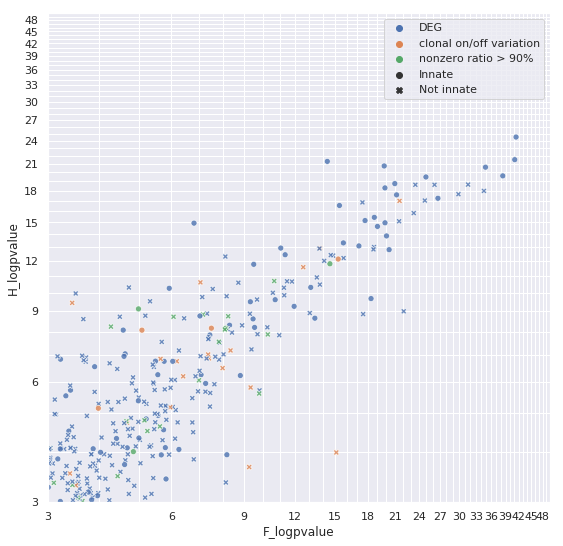

In [127]:
fix,ax = plt.subplots(figsize=(9,9))
oftenlist = ['nonzero ratio > 90%' if (DE_frame.loc[gene,'Nonzero Ratio'] >= 0.9 and DE_frame.loc[gene,'F_logpvalue'] > 6) 
             else 'clonal on/off variation' if (DE_frame.loc[gene,'Nonzero Ratio'] < 0.9 and DE_frame.loc[gene,'chi2_logpvalue'] > 6)
             else 'DEG' 
             for gene in genes_DE ]
#chilist = ['onoff' if x < 1e-3 else 'not onoff' for x in DE_frame['chi2_logpvalue']]
inn_list = ['Innate' if DE_frame.loc[gene, 'Is innate']
            else 'Not innate'
           for gene in DE_frame.index]
sns.scatterplot(x='F_logpvalue', y='H_logpvalue', hue = oftenlist, style = inn_list, data=DE_frame, alpha=0.8, ax=ax)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xbound(6,50)
ax.set_ybound(6,50)

ax.set_xticks(range(3,50))
ax.set_yticks(range(3,50))
ll = list(range(3,50))
for j in range(len(ll)):
    if (ll[j]%3 != 0) and (ll[j] > 3):
        ll[j] = ''
ax.set_xticklabels(ll)
ax.set_yticklabels(ll)
ax.minorticks_off()

plt.show()